# CT Tomographic Reconstruction - Practical Exercise
## Formal and Hybrid Methods for Medical Imaging Course

**Lesson Objectives:**
- Implement CT reconstruction algorithms
- Simulate the acquisition process
- Compare different reconstruction methods
- Analyze artifacts and noise

---


## Module 1.1: Setup and Library Import

Before starting, let's install and import all necessary libraries.


In [5]:
# Library installation (uncomment if necessary)
# !pip install numpy scipy matplotlib scikit-image

# To use the Deep Learning section, also install TensorFlow:
# !pip install tensorflow

# On Google Colab, TensorFlow is already pre-installed!
# On macOS with M1/M2 chips, use: pip install tensorflow-macos tensorflow-metal

import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy.fft import fft, ifft, fftfreq
from skimage import data, transform
from skimage.transform import radon, iradon
import warnings
warnings.filterwarnings('ignore')

# Plot configuration
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

print("✅ Libraries imported successfully!")


✅ Libraries imported successfully!


## Creating Test Phantoms

Let's start by creating some "phantoms" (test objects) to simulate the CT reconstruction process:

- simple phantom that we create as an overlay of geometric objects
- Shepp-Logan phantom -> classic reference for CT reconstruction that we implement from skimage


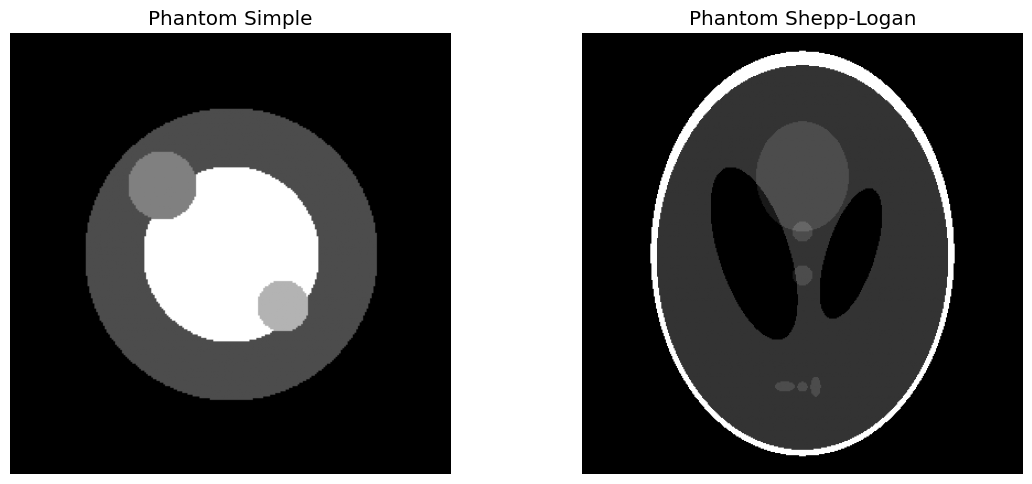

✅ Phantoms created - Dimensions: (256, 256)


In [8]:
def create_simple_phantom(size=256):
    """
    Create a simple phantom with circles of different densities
    """
    phantom = np.zeros((size, size))

    # Center of image
    center = size // 2

    # Grid of coordinates
    y, x = np.ogrid[:size, :size]

    # Large outer circle (low density)
    mask1 = (x - center)**2 + (y - center)**2 < (size//3)**2
    phantom[mask1] = 0.3

    # Medium circle (high density)
    mask2 = (x - center)**2 + (y - center)**2 < (size//5)**2
    phantom[mask2] = 1.0

    # Small inner circles
    # Circle in upper right
    mask3 = (x - center - 30)**2 + (y - center - 30)**2 < 15**2
    phantom[mask3] = 0.7

    # Circle in lower left
    mask4 = (x - center + 40)**2 + (y - center + 40)**2 < 20**2
    phantom[mask4] = 0.5

    return phantom

def create_shepp_logan_phantom(size=256):
    """
    Create the classic Shepp-Logan phantom
    """
    # We use the phantom already implemented in scikit-image
    from skimage.data import shepp_logan_phantom
    return shepp_logan_phantom()

# Let's create our phantoms
phantom_simple = create_simple_phantom(256)
phantom_shepp = create_shepp_logan_phantom()

# Visualize the phantoms
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].imshow(phantom_simple, cmap='gray')
axes[0].set_title('Phantom Simple')
axes[0].axis('off')

axes[1].imshow(phantom_shepp, cmap='gray')
axes[1].set_title('Phantom Shepp-Logan')
axes[1].axis('off')

plt.tight_layout()
plt.show()

print(f"✅ Phantoms created - Dimensions: {phantom_simple.shape}")


### 🎯 **Exercise 1**: Create your custom phantom

Modify the `create_simple_phantom()` function to create a phantom with:
- A square in the center
- Three circles of different densities in the corners
- A diagonal line


In [ ]:
def create_custom_phantom(size=256):
    """
    Create a custom phantom
    """
    phantom = np.zeros((size, size))
    center = size // 2

    # TODO: Implement your custom phantom
    # Hints:
    # - Use phantom[y1:y2, x1:x2] = value for squares
    # - Use np.ogrid to create circles
    # - Use np.diag() or slicing for lines

    return phantom

# Test your phantom
# phantom_custom = create_custom_phantom()
# plt.imshow(phantom_custom, cmap='gray')
# plt.title('My Phantom')
# plt.axis('off')
# plt.show()


## Module 1.2: Simulation of the Acquisition Process

Now let's simulate the CT acquisition process by generating projections (sinogram) of our phantom (default=phantom_simple).


In [9]:
def simulate_ct_acquisition(phantom, n_angles=180, noise_level=0.0):
    """
    Simulate CT acquisition of a phantom

    Parameters:
    - phantom: 2D phantom image
    - n_angles: number of projection angles
    - noise_level: noise level to add

    Returns:
    - sinogram: sinogram (projections)
    - angles: angles used
    """
    # Projection angles (from 0 to 180 degrees)
    angles = np.linspace(0, 180, n_angles, endpoint=False)

    # Calculation of Radon transform (sinogram)
    sinogram = radon(phantom, theta=angles, circle=True)

    # Adding noise if requested
    if noise_level > 0:
        noise = np.random.normal(0, noise_level, sinogram.shape)
        sinogram += noise

    return sinogram, angles

# Simulate acquisition for the simple phantom
sinogram, angles = simulate_ct_acquisition(phantom_simple, n_angles=180)

print(f"✅ Sinogram generated - Dimensions: {sinogram.shape}")
print(f"📐 Angles: from {angles[0]:.1f}° to {angles[-1]:.1f}°")
print(f"📏 Number of projections: {len(angles)}")


✅ Sinogram generated - Dimensions: (256, 180)
📐 Angles: from 0.0° to 179.0°
📏 Number of projections: 180


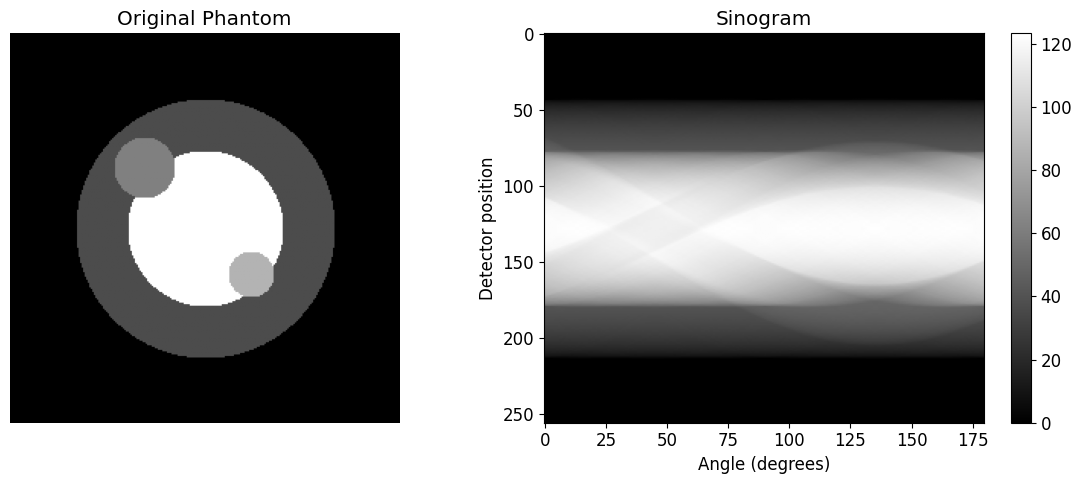

In [11]:
# Visualize the sinogram
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Original phantom
axes[0].imshow(phantom_simple, cmap='gray')
axes[0].set_title('Original Phantom')
axes[0].axis('off')

# Sinogram
im = axes[1].imshow(sinogram, cmap='gray', aspect='auto')
axes[1].set_title('Sinogram')
axes[1].set_xlabel('Angle (degrees)')
axes[1].set_ylabel('Detector position')
plt.colorbar(im, ax=axes[1])

plt.tight_layout()
plt.show()


## Module 1.3: Simple Backprojection

Let's implement the simple backprojection algorithm to see what happens without filters.

### Quality Metric: Mean Squared Error (MSE)

To evaluate reconstruction quality, we'll use the **Mean Squared Error (MSE)**, which measures the average squared difference between the original phantom and the reconstructed image:

$$MSE = \frac{1}{N} \sum_{i=1}^{N} (x_i - \hat{x}_i)^2$$

where:
- $N$ = total number of pixels
- $x_i$ = pixel value in the original phantom
- $\hat{x}_i$ = pixel value in the reconstructed image

**Lower MSE = better reconstruction quality**. The squaring penalizes large errors more heavily, making MSE particularly sensitive to significant artifacts or distortions in the reconstructed image.


In [12]:
def simple_backprojection(sinogram, angles):
    """
    Implements simple backprojection

    Parameters:
    - sinogram: sinogram to reconstruct
    - angles: projection angles

    Returns:
    - reconstruction: reconstructed image
    """
    # Use iradon function with filter=None for simple backprojection
    reconstruction = iradon(sinogram, theta=angles, filter_name=None, circle=True)

    return reconstruction

# Reconstruct with simple backprojection
reconstruction_simple = simple_backprojection(sinogram, angles)

print(f"✅ Reconstruction completed - Dimensions: {reconstruction_simple.shape}")


✅ Reconstruction completed - Dimensions: (256, 256)


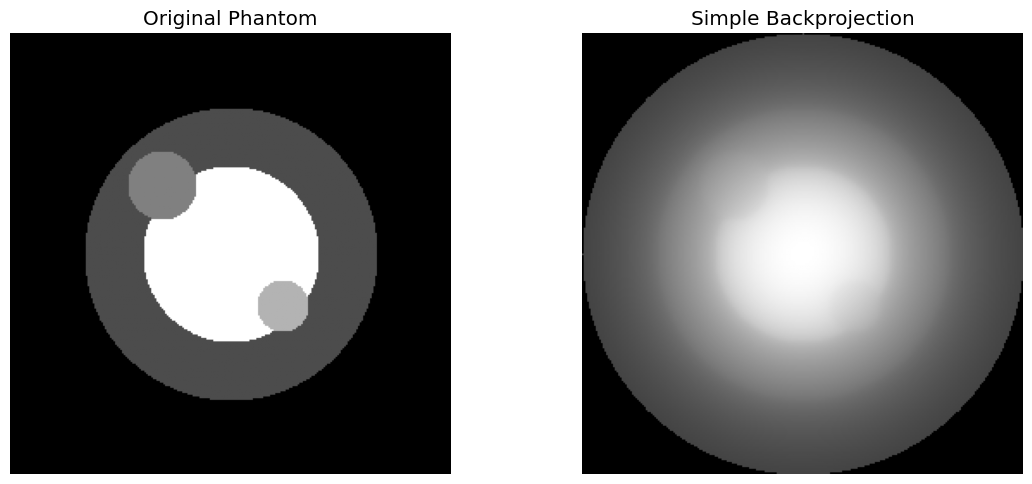

📊 Mean Squared Error: 7956.887113
📊 Original maximum value: 1.000
📊 Reconstructed maximum value: 189.835


In [13]:
# Compare original vs simple reconstruction
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Original phantom
axes[0].imshow(phantom_simple, cmap='gray')
axes[0].set_title('Original Phantom')
axes[0].axis('off')

# Simple reconstruction
axes[1].imshow(reconstruction_simple, cmap='gray')
axes[1].set_title('Simple Backprojection')
axes[1].axis('off')

plt.tight_layout()
plt.show()

# Calculate some quality metrics
mse = np.mean((phantom_simple - reconstruction_simple)**2)
print(f"📊 Mean Squared Error: {mse:.6f}")
print(f"📊 Original maximum value: {phantom_simple.max():.3f}")
print(f"📊 Reconstructed maximum value: {reconstruction_simple.max():.3f}")


## Module 1.4: Filtered Back Projection (FBP)

#### Now let's implement Filtered Back Projection to obtain better quality reconstructions. The proposed filters are:
- Ramp Filter (Ram-Lak): basic and most fundamental filter for FBP. Mathematically perfectly compensates for the intrinsic blur of simple backprojection. Tends to amplify noise at high frequencies.
- Shepp-Logan Filter: modified version of the ramp filter with high frequency attenuation. Offers a compromise between image quality and noise reduction, reduces noise artifacts compared to the pure ramp filter. It attenuate gradually the high frequences.
- Hamming Filter: applies a Hamming window to the ramp filter. Strong attenuation of high frequencies, significantly reduces noise but may cause loss of resolution. Useful when the signal-to-noise ratio is very low.


In [15]:
def fbp_reconstruction(sinogram, angles, filter_name='ramp'):
    """
    Implements Filtered Back Projection

    Parameters:
    - sinogram: sinogram to reconstruct
    - angles: projection angles
    - filter_name: filter type ('ramp', 'shepp-logan', 'hamming')

    Returns:
    - reconstruction: reconstructed image
    """
    reconstruction = iradon(sinogram, theta=angles, filter_name=filter_name, circle=True)
    return reconstruction

# Test different filters
filters = ['ramp', 'shepp-logan', 'hamming']
reconstructions = {}

for filter_name in filters:
    reconstructions[filter_name] = fbp_reconstruction(sinogram, angles, filter_name)
    print(f"✅ Reconstruction with {filter_name} filter completed")


✅ Reconstruction with ramp filter completed
✅ Reconstruction with shepp-logan filter completed
✅ Reconstruction with hamming filter completed


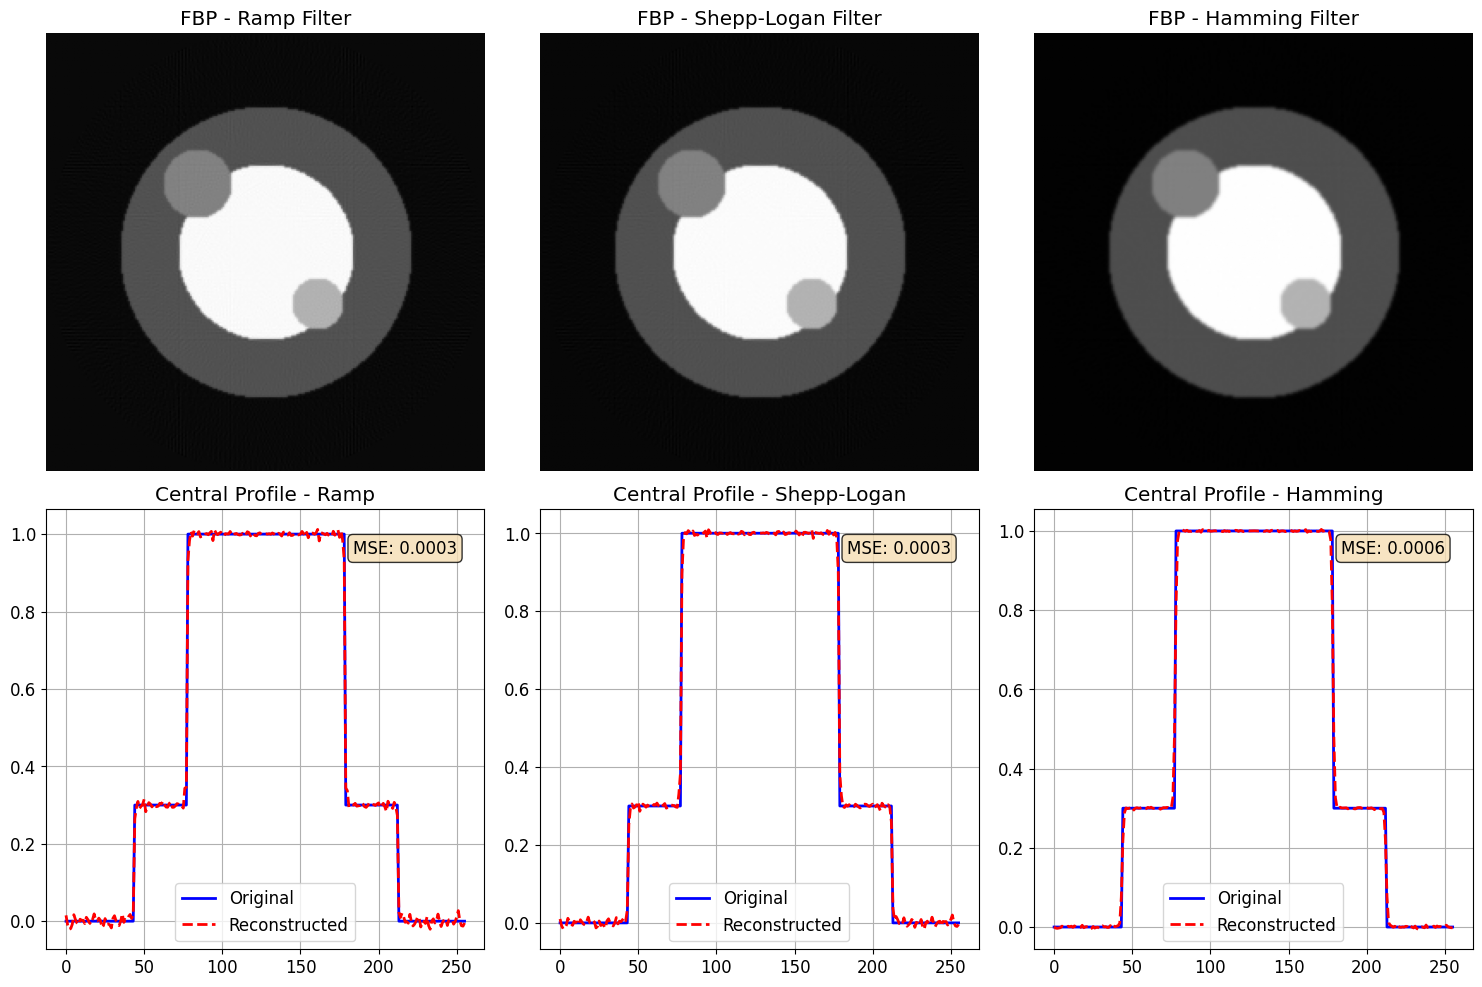

In [16]:
# Compare different filters
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# First row: reconstructions
for i, (filter_name, reconstruction) in enumerate(reconstructions.items()):
    axes[0, i].imshow(reconstruction, cmap='gray')
    axes[0, i].set_title(f'FBP - {filter_name.title()} Filter')
    axes[0, i].axis('off')

# Second row: central profiles
center_idx = phantom_simple.shape[0] // 2
original_profile = phantom_simple[center_idx, :]

for i, (filter_name, reconstruction) in enumerate(reconstructions.items()):
    reconstructed_profile = reconstruction[center_idx, :]

    axes[1, i].plot(original_profile, 'b-', label='Original', linewidth=2)
    axes[1, i].plot(reconstructed_profile, 'r--', label='Reconstructed', linewidth=2)
    axes[1, i].set_title(f'Central Profile - {filter_name.title()}')
    axes[1, i].legend()
    axes[1, i].grid(True)

    # Calculate MSE for this filter
    mse = np.mean((phantom_simple - reconstruction)**2)
    axes[1, i].text(0.7, 0.9, f'MSE: {mse:.4f}', transform=axes[1, i].transAxes,
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.show()


## Module 1.5: Effects of Noise and Undersampling

Let's analyze how noise and limited number of projections affect reconstruction.


Noise 0.0: MSE = 0.000324
Noise 0.5: MSE = 0.000600
Noise 1: MSE = 0.001414
Noise 5: MSE = 0.028210


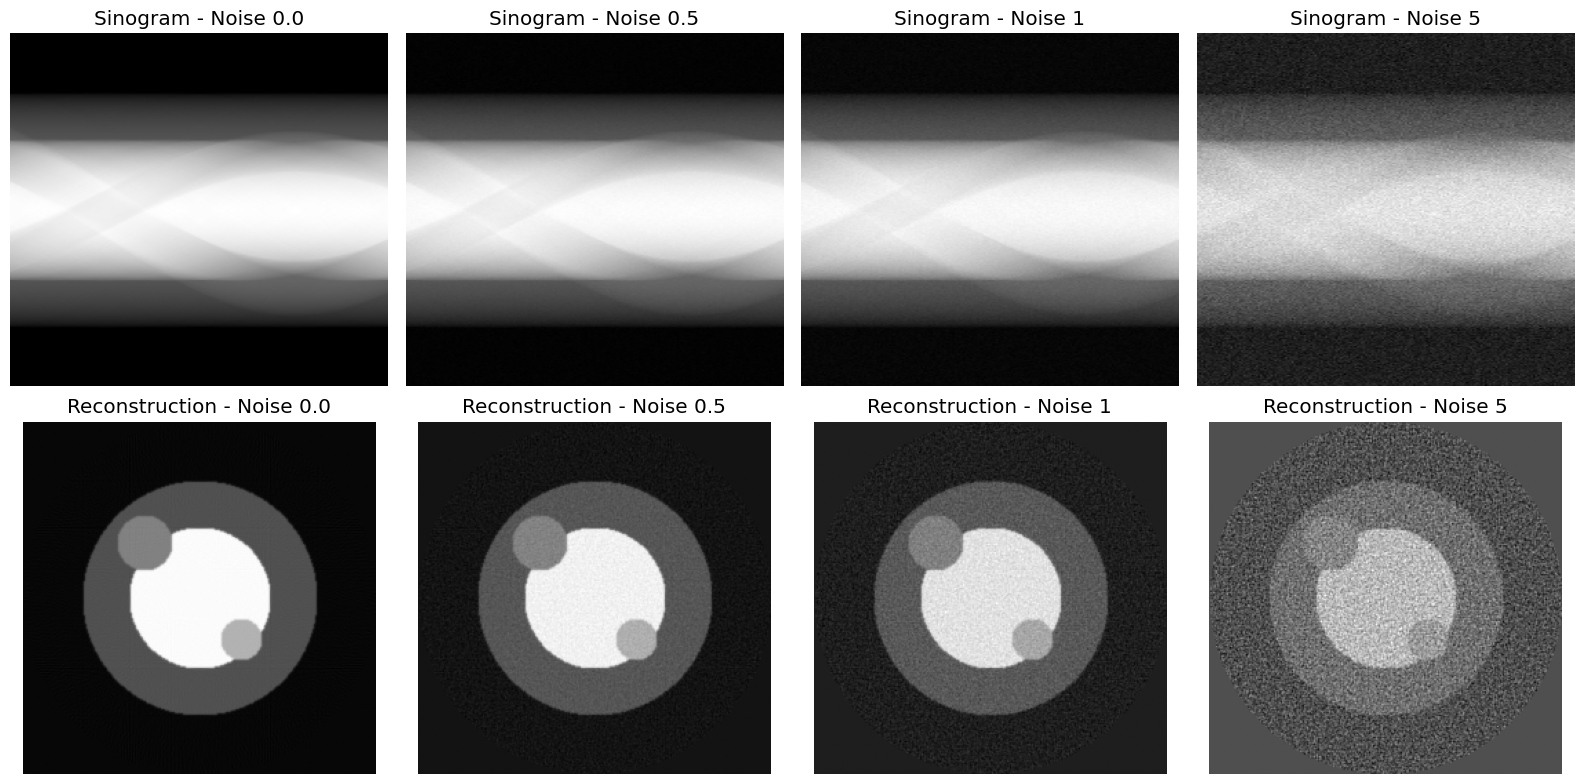

In [17]:
# Simulate acquisitions with different noise levels
noise_levels = [0.0, 0.5, 1, 5]

fig, axes = plt.subplots(2, len(noise_levels), figsize=(16, 8))

for i, noise_level in enumerate(noise_levels):
    # Acquisition with noise
    sinogram_noisy, _ = simulate_ct_acquisition(phantom_simple, n_angles=180,
                                               noise_level=noise_level)

    # FBP reconstruction
    reconstruction_noisy = fbp_reconstruction(sinogram_noisy, angles, 'shepp-logan')

    # Visualization
    axes[0, i].imshow(sinogram_noisy, cmap='gray', aspect='auto')
    axes[0, i].set_title(f'Sinogram - Noise {noise_level}')
    axes[0, i].axis('off')

    axes[1, i].imshow(reconstruction_noisy, cmap='gray')
    axes[1, i].set_title(f'Reconstruction - Noise {noise_level}')
    axes[1, i].axis('off')

    # Calculate quality
    mse = np.mean((phantom_simple - reconstruction_noisy)**2)
    print(f"Noise {noise_level}: MSE = {mse:.6f}")

plt.tight_layout()
plt.show()

### 🎯 **Exercise 2**: Analysis of the Effect of Number of Projections

Compare reconstruction quality with different numbers of projections.


45 projections: MSE = 0.001523
90 projections: MSE = 0.000503
180 projections: MSE = 0.000324
360 projections: MSE = 0.000305


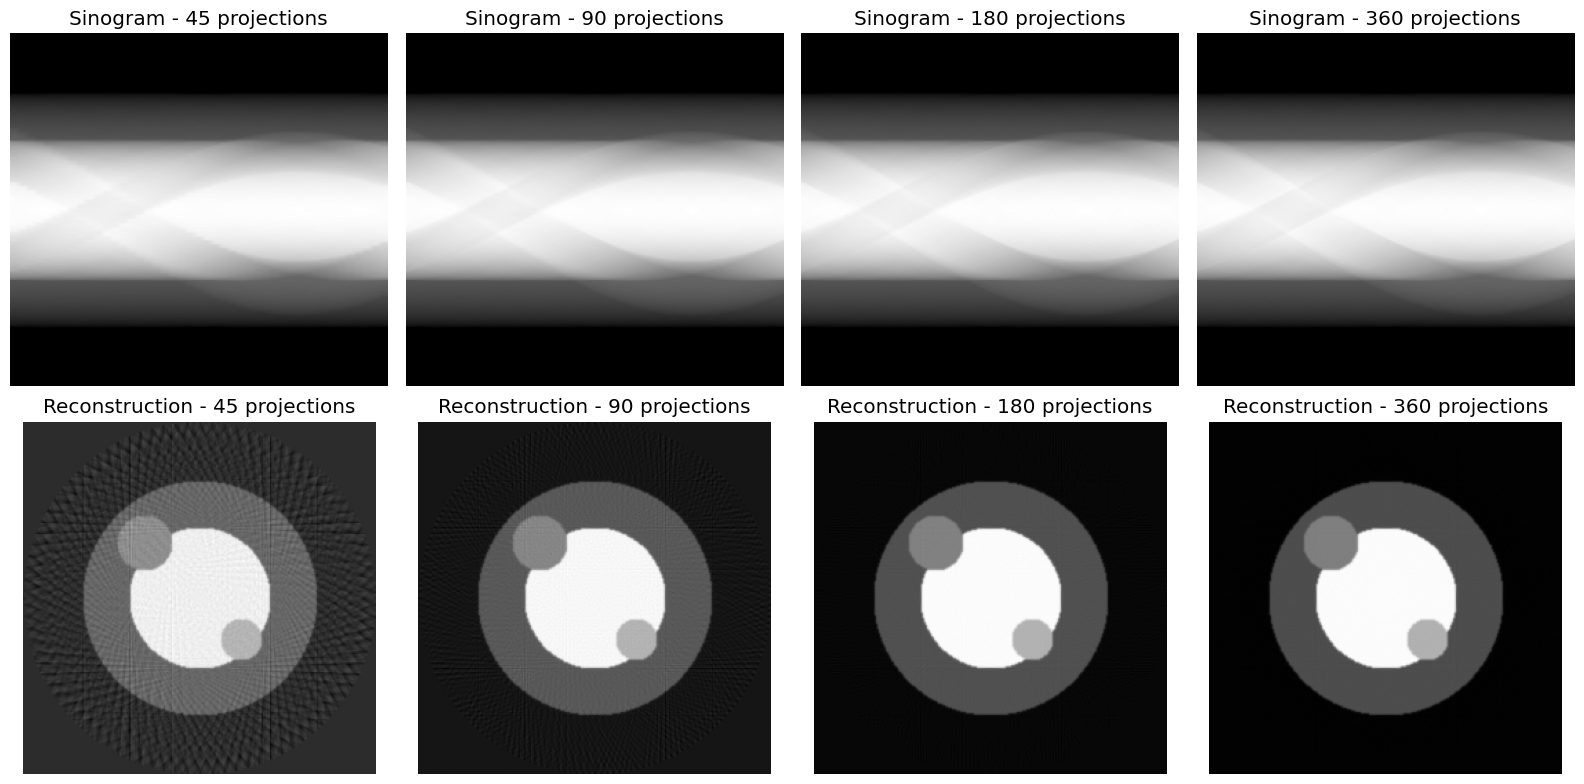

In [24]:
angles_counts = [45, 90, 180, 360]

fig, axes = plt.subplots(2, len(angles_counts), figsize=(16, 8))

for i, n_angles in enumerate(angles_counts):
    # Acquisition with n_angles projections
    sinogram_sparse, angles_sparse = simulate_ct_acquisition(phantom_simple,
                                                           n_angles=n_angles)

    # FBP reconstruction
    reconstruction_sparse = fbp_reconstruction(sinogram_sparse, angles_sparse,
                                             'shepp-logan')

    # Visualization
    axes[0, i].imshow(sinogram_sparse, cmap='gray', aspect='auto')
    axes[0, i].set_title(f'Sinogram - {n_angles} projections')
    axes[0, i].axis('off')

    axes[1, i].imshow(reconstruction_sparse, cmap='gray')
    axes[1, i].set_title(f'Reconstruction - {n_angles} projections')
    axes[1, i].axis('off')

    # Calculate quality
    mse = np.mean((phantom_simple - reconstruction_sparse)**2)
    print(f"{n_angles} projections: MSE = {mse:.6f}")

plt.tight_layout()
plt.show()

### 🎯 Exercise 3: Complete Comparison with Shepp-Logan Phantom

Let's test all our algorithms on the classic Shepp-Logan phantom and calculate quality metrics.

#### Quality Metrics Used

**MSE (Mean Squared Error)**
- Measures the average squared difference between the original phantom and the reconstructed image
- Lower values indicate better reconstruction quality
- Highly sensitive to outliers and large errors
- Most commonly used metric due to simplicity and mathematical tractability

**PSNR (Peak Signal-to-Noise Ratio)**
- Quantifies the ratio between the maximum possible signal power and the  corrupting noise power, expressed in decibels (dB)
- Higher values indicate better reconstruction quality (typically 20-50 dB)
- Related to MSE but provides a logarithmic scale that better matches human perception
- Values above 30 dB generally indicate good quality

**SSIM (Structural Similarity Index)**
- Assesses perceived image quality by comparing structural information, luminance, and contrast between images
- Values range from -1 to 1, where 1 means perfect similarity
- Better reflects human visual perception than MSE or PSNR
- Considers local patterns and spatial correlations in the image
- Particularly useful for medical imaging where structural fidelity is critical

In [18]:
def calculate_quality_metrics(original, reconstructed):
    """
    Calculate quality metrics for reconstruction
    """
    # Mean Squared Error
    mse = np.mean((original - reconstructed)**2)

    # Peak Signal-to-Noise Ratio
    if mse > 0:
        psnr = 20 * np.log10(original.max()) - 10 * np.log10(mse)
    else:
        psnr = float('inf')

    # Structural Similarity Index (simplified version)
    mean_orig = np.mean(original)
    mean_recon = np.mean(reconstructed)
    var_orig = np.var(original)
    var_recon = np.var(reconstructed)
    cov = np.mean((original - mean_orig) * (reconstructed - mean_recon))

    c1, c2 = 0.01, 0.03  # Constants for numerical stability
    ssim = ((2*mean_orig*mean_recon + c1) * (2*cov + c2)) / \
           ((mean_orig**2 + mean_recon**2 + c1) * (var_orig + var_recon + c2))

    return {
        'MSE': mse,
        'PSNR': psnr,
        'SSIM': ssim
    }

# Complete test with Shepp-Logan phantom
phantom_test = phantom_shepp

# Acquisition with noise
sinogram_test, angles_test = simulate_ct_acquisition(phantom_test, n_angles=180,
                                                   noise_level=0.05)

# Reconstructions with different methods
reconstruction_bp = simple_backprojection(sinogram_test, angles_test)
reconstruction_fbp_ramp = fbp_reconstruction(sinogram_test, angles_test, 'ramp')
reconstruction_fbp_shepp = fbp_reconstruction(sinogram_test, angles_test, 'shepp-logan')

print("✅ All reconstructions completed!")


✅ All reconstructions completed!


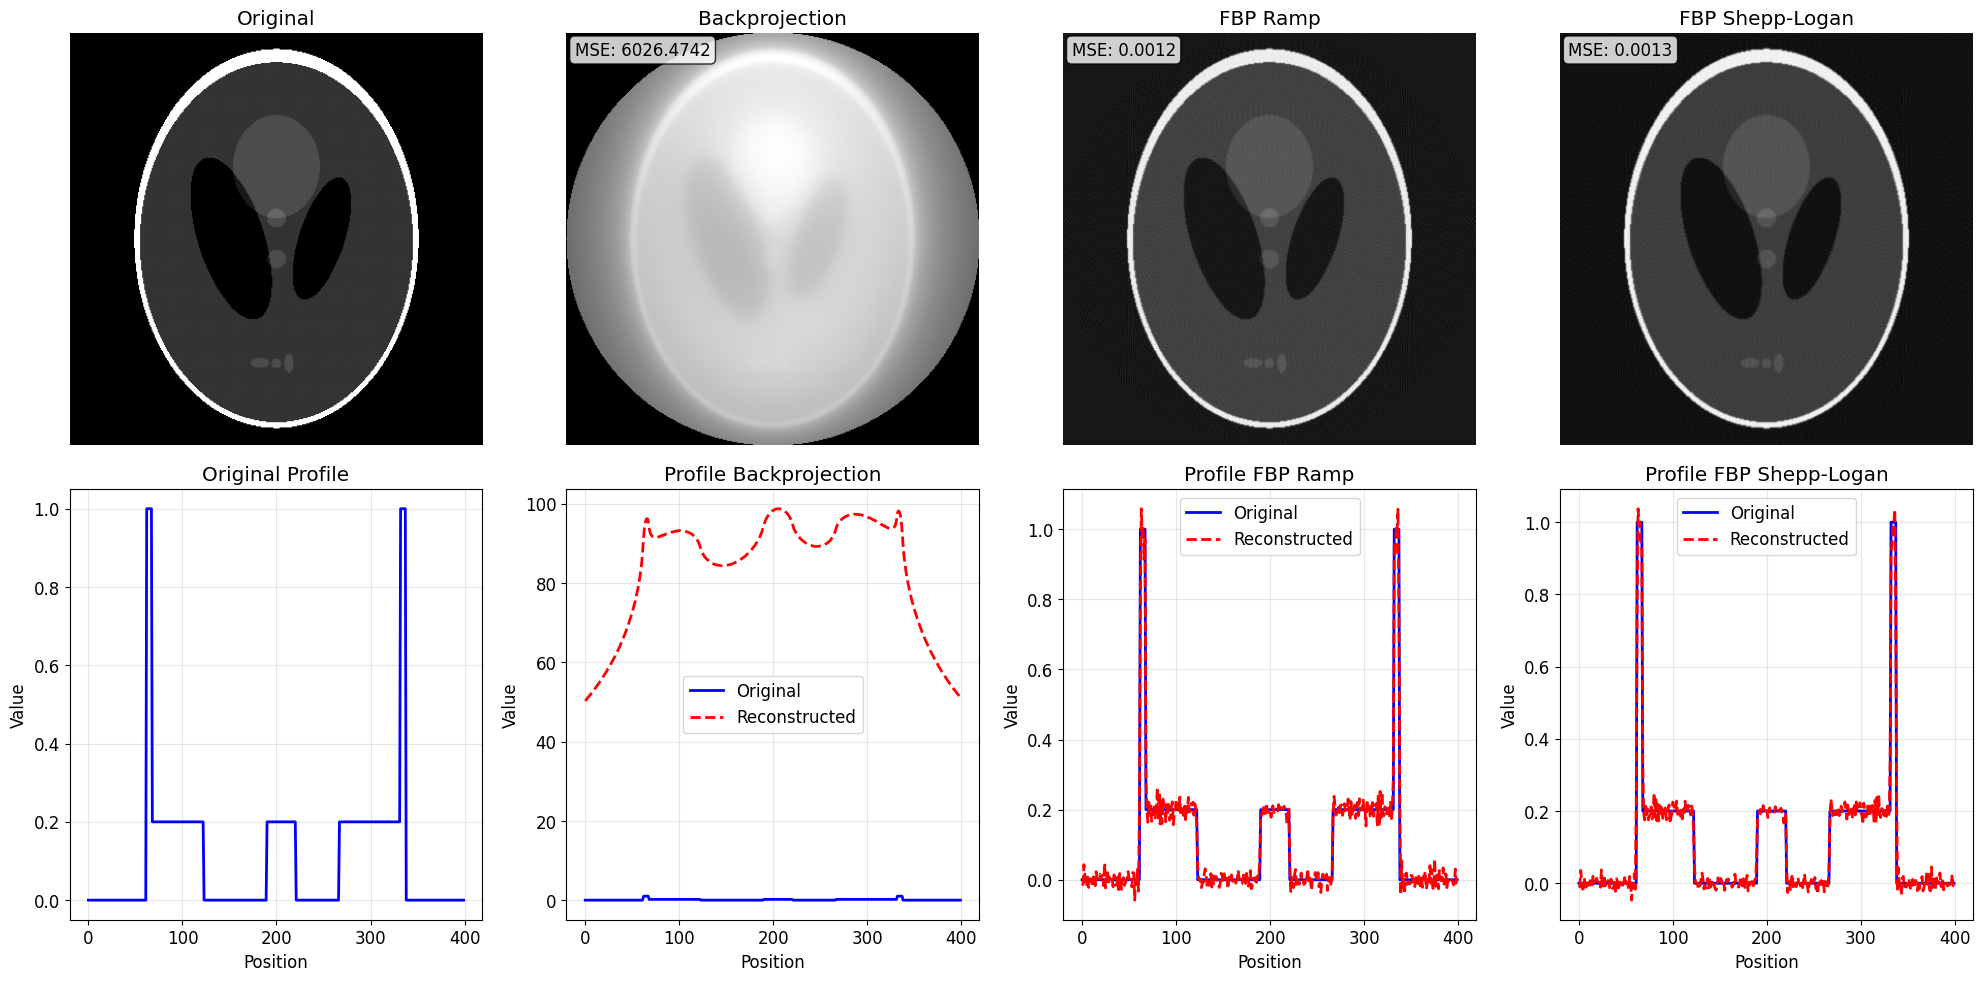

📊 QUALITY METRICS
Method               MSE        PSNR       SSIM      
--------------------------------------------------
Backprojection       6026.474241 -37.80     0.0000    
FBP Ramp             0.001179   29.29      0.9901    
FBP Shepp-Logan      0.001291   28.89      0.9891    


In [19]:
# Final comparative visualization
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

# First row: images
images = [phantom_test, reconstruction_bp, reconstruction_fbp_ramp, reconstruction_fbp_shepp]
titles = ['Original', 'Backprojection', 'FBP Ramp', 'FBP Shepp-Logan']

for i, (img, title) in enumerate(zip(images, titles)):
    axes[0, i].imshow(img, cmap='gray')
    axes[0, i].set_title(title)
    axes[0, i].axis('off')

    if i > 0:  # Calculate MSE for reconstructions
        mse = np.mean((phantom_test - img)**2)
        axes[0, i].text(0.02, 0.98, f'MSE: {mse:.4f}', transform=axes[0, i].transAxes,
                       verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Second row: profiles
center_row = phantom_test.shape[0] // 2
original_profile = phantom_test[center_row, :]

for i, (img, title) in enumerate(zip(images, titles)):
    if i == 0:
        axes[1, i].plot(original_profile, 'b-', linewidth=2, label='Original')
        axes[1, i].set_title('Original Profile')
    else:
        profile = img[center_row, :]
        axes[1, i].plot(original_profile, 'b-', linewidth=2, label='Original')
        axes[1, i].plot(profile, 'r--', linewidth=2, label='Reconstructed')
        axes[1, i].set_title(f'Profile {title}')
        axes[1, i].legend()

    axes[1, i].grid(True, alpha=0.3)
    axes[1, i].set_xlabel('Position')
    axes[1, i].set_ylabel('Value')

plt.tight_layout()
plt.show()

# Calculate metrics for all methods
methods = {
    'Backprojection': reconstruction_bp,
    'FBP Ramp': reconstruction_fbp_ramp,
    'FBP Shepp-Logan': reconstruction_fbp_shepp
}

print("📊 QUALITY METRICS")
print("=" * 50)
print(f"{'Method':<20} {'MSE':<10} {'PSNR':<10} {'SSIM':<10}")
print("-" * 50)

for method_name, reconstruction in methods.items():
    metrics = calculate_quality_metrics(phantom_test, reconstruction)
    print(f"{method_name:<20} {metrics['MSE']:<10.6f} {metrics['PSNR']:<10.2f} {metrics['SSIM']:<10.4f}")

## Module 2.1: Iterative Methods - SIRT and SART

Iterative methods solve the CT reconstruction problem through an iterative process that converges toward the solution. They are particularly useful for:

- **Few projections** (sparse-view CT)
- **High noise**
- **Non-standard geometries**


In [20]:
def sirt_reconstruction(sinogram, angles, n_iterations=50, relaxation=1.0, initial_image=None, reference_image=None):
    """
    Implements the SIRT algorithm (Simultaneous Iterative Reconstruction Technique)

    Parameters:
    - sinogram: sinogram to reconstruct
    - angles: projection angles
    - n_iterations: number of iterations
    - relaxation: relaxation parameter (0 < λ ≤ 1)
    - initial_image: initial image (optional)
    - reference_image: reference image to calculate MSE (optional)

    Returns:
    - reconstruction: reconstructed image
    - errors: list of errors per iteration
    - image_errors: list of image errors (if reference_image provided)
    """

    # Dimensions
    n_detectors, n_angles = sinogram.shape
    image_size = n_detectors

    # Initialization with FBP to have a good starting point
    if initial_image is None:
        x = iradon(sinogram, theta=angles, filter_name='ramp', circle=True)
        x = np.maximum(x, 0)  # Non-negativity constraint
    else:
        x = initial_image.copy()

    errors = []
    image_errors = []

    print(f"🔄 Starting SIRT with {n_iterations} iterations...")

    for iteration in range(n_iterations):
        # Calculate projections of current image
        projected_sinogram = radon(x, theta=angles, circle=True)

        # Calculate residual
        residual = sinogram - projected_sinogram

        # Sinogram error for monitoring
        sinogram_error = np.linalg.norm(residual)
        errors.append(sinogram_error)

        # Image error (if reference provided)
        if reference_image is not None:
            image_error = np.mean((reference_image - x)**2)
            image_errors.append(image_error)

        # SIRT: Backprojection with row normalization
        correction = np.zeros_like(x)

        for i in range(n_angles):
            # Single projection
            single_proj = radon(x, theta=[angles[i]], circle=True)

            # Residual for this projection
            residual_proj = sinogram[:, i] - single_proj[:, 0]

            # Backprojection of residual
            residual_sinogram = np.zeros_like(sinogram)
            residual_sinogram[:, i] = residual_proj

            backproj = iradon(residual_sinogram, theta=angles, filter_name=None, circle=True)

            # Normalize by number of pixels in projection
            # (approximation: image diameter)
            normalization = n_detectors * 0.7  # Empirical factor for circle
            correction += backproj / normalization

        # Normalize by number of projections
        correction = correction / n_angles

        # Update image
        x = x + relaxation * correction

        # Non-negativity constraint
        x = np.maximum(x, 0)

        # Print progress
        if (iteration + 1) % 10 == 0:
            if reference_image is not None:
                print(f"   Iteration {iteration + 1}/{n_iterations}: Sinogram Error = {sinogram_error:.6f}, Image MSE = {image_error:.6f}")
            else:
                print(f"   Iteration {iteration + 1}/{n_iterations}: Error = {sinogram_error:.6f}")

    print(f"✅ SIRT completed!")
    return x, errors, image_errors if reference_image is not None else None


In [21]:
def sart_reconstruction(sinogram, angles, n_iterations=50, relaxation=1.0, initial_image=None):
    """
    Implements the SART algorithm (Simultaneous Algebraic Reconstruction Technique)

    SART is a variant of SIRT that updates the image after each projection:
    - More numerically stable
    - Faster convergence
    - Better for noisy data

    Parameters:
    - sinogram: sinogram to reconstruct
    - angles: projection angles
    - n_iterations: number of iterations (cycles through all projections)
    - relaxation: relaxation parameter
    - initial_image: initial image (optional)

    Returns:
    - reconstruction: reconstructed image
    - errors: list of errors per iteration
    """
    from skimage.transform import radon, iradon

    # Dimensions
    n_detectors, n_angles = sinogram.shape

    # Initialization
    if initial_image is None:
        x = iradon(sinogram, theta=angles, filter_name=None, circle=True)
        x = np.maximum(x, 0)
    else:
        x = initial_image.copy()

    errors = []

    print(f"🔄 Starting SART with {n_iterations} iterations...")

    for iteration in range(n_iterations):
        total_error = 0

        # One SART iteration = cycle through all projections
        for proj_idx in range(n_angles):
            # Single projection of current image
            single_projection = radon(x, theta=[angles[proj_idx]], circle=True)

            # Calculate residual for this projection
            residual_proj = sinogram[:, proj_idx] - single_projection[:, 0]

            # Backprojection of residual for this projection
            residual_sinogram = np.zeros_like(sinogram)
            residual_sinogram[:, proj_idx] = residual_proj

            correction = iradon(residual_sinogram, theta=angles, filter_name=None, circle=True)

            # Normalize by number of rays per pixel (approximation)
            correction = correction / (n_angles * 0.5)

            # Update image
            x = x + relaxation * correction

            # Apply non-negativity constraint
            x = np.maximum(x, 0)

            # Accumulate error
            total_error += np.sum(residual_proj**2)

        # Calculate average error for this iteration
        avg_error = np.sqrt(total_error / (n_detectors * n_angles))
        errors.append(avg_error)

        # Print progress every 10 iterations
        if (iteration + 1) % 10 == 0:
            print(f"   Iteration {iteration + 1}/{n_iterations}: Error = {avg_error:.6f}")

    print(f"✅ SART completed!")
    return x, errors

In [24]:
# Test of iterative methods with sparse projection scenario
print("🧪 Test of Iterative Methods")
print("=" * 50)

# Create a sinogram with few projections to test iterative methods
print("1️⃣ Acquisition with few projections (45 instead of 180)...")
sinogram_sparse, angles_sparse = simulate_ct_acquisition(
    phantom_simple,
    n_angles=45,  # Few projections
    noise_level=0.05  # With moderate noise
)

print(f"   ✅ Sinogram: {sinogram_sparse.shape} with {len(angles_sparse)} projections")

# FBP reconstruction for comparison
print("\n2️⃣ FBP Reconstruction (reference)...")
recon_fbp_sparse = fbp_reconstruction(sinogram_sparse, angles_sparse, 'shepp-logan')
print(f"   ✅ FBP completed")

# SIRT reconstruction
print("\n3️⃣ SIRT Reconstruction...")
recon_sirt, errors_sirt, image_errors_sirt = sirt_reconstruction(
    sinogram_sparse,
    angles_sparse,
    n_iterations=10,
    relaxation=0.9,
    reference_image=phantom_simple
)

# SART reconstruction
print("\n4️⃣ SART Reconstruction...")
recon_sart, errors_sart = sart_reconstruction(
    sinogram_sparse,
    angles_sparse,
    n_iterations=10,
    relaxation=0.9
)

print("🎯 All reconstructions completed!")

🧪 Test of Iterative Methods
1️⃣ Acquisition with few projections (45 instead of 180)...
   ✅ Sinogram: (256, 45) with 45 projections

2️⃣ FBP Reconstruction (reference)...
   ✅ FBP completed

3️⃣ SIRT Reconstruction...
🔄 Starting SIRT with 10 iterations...
   Iteration 10/10: Sinogram Error = 215.653289, Image MSE = 0.001147
✅ SIRT completed!

4️⃣ SART Reconstruction...
🔄 Starting SART with 10 iterations...
   Iteration 10/10: Error = 2.560843
✅ SART completed!
🎯 All reconstructions completed!


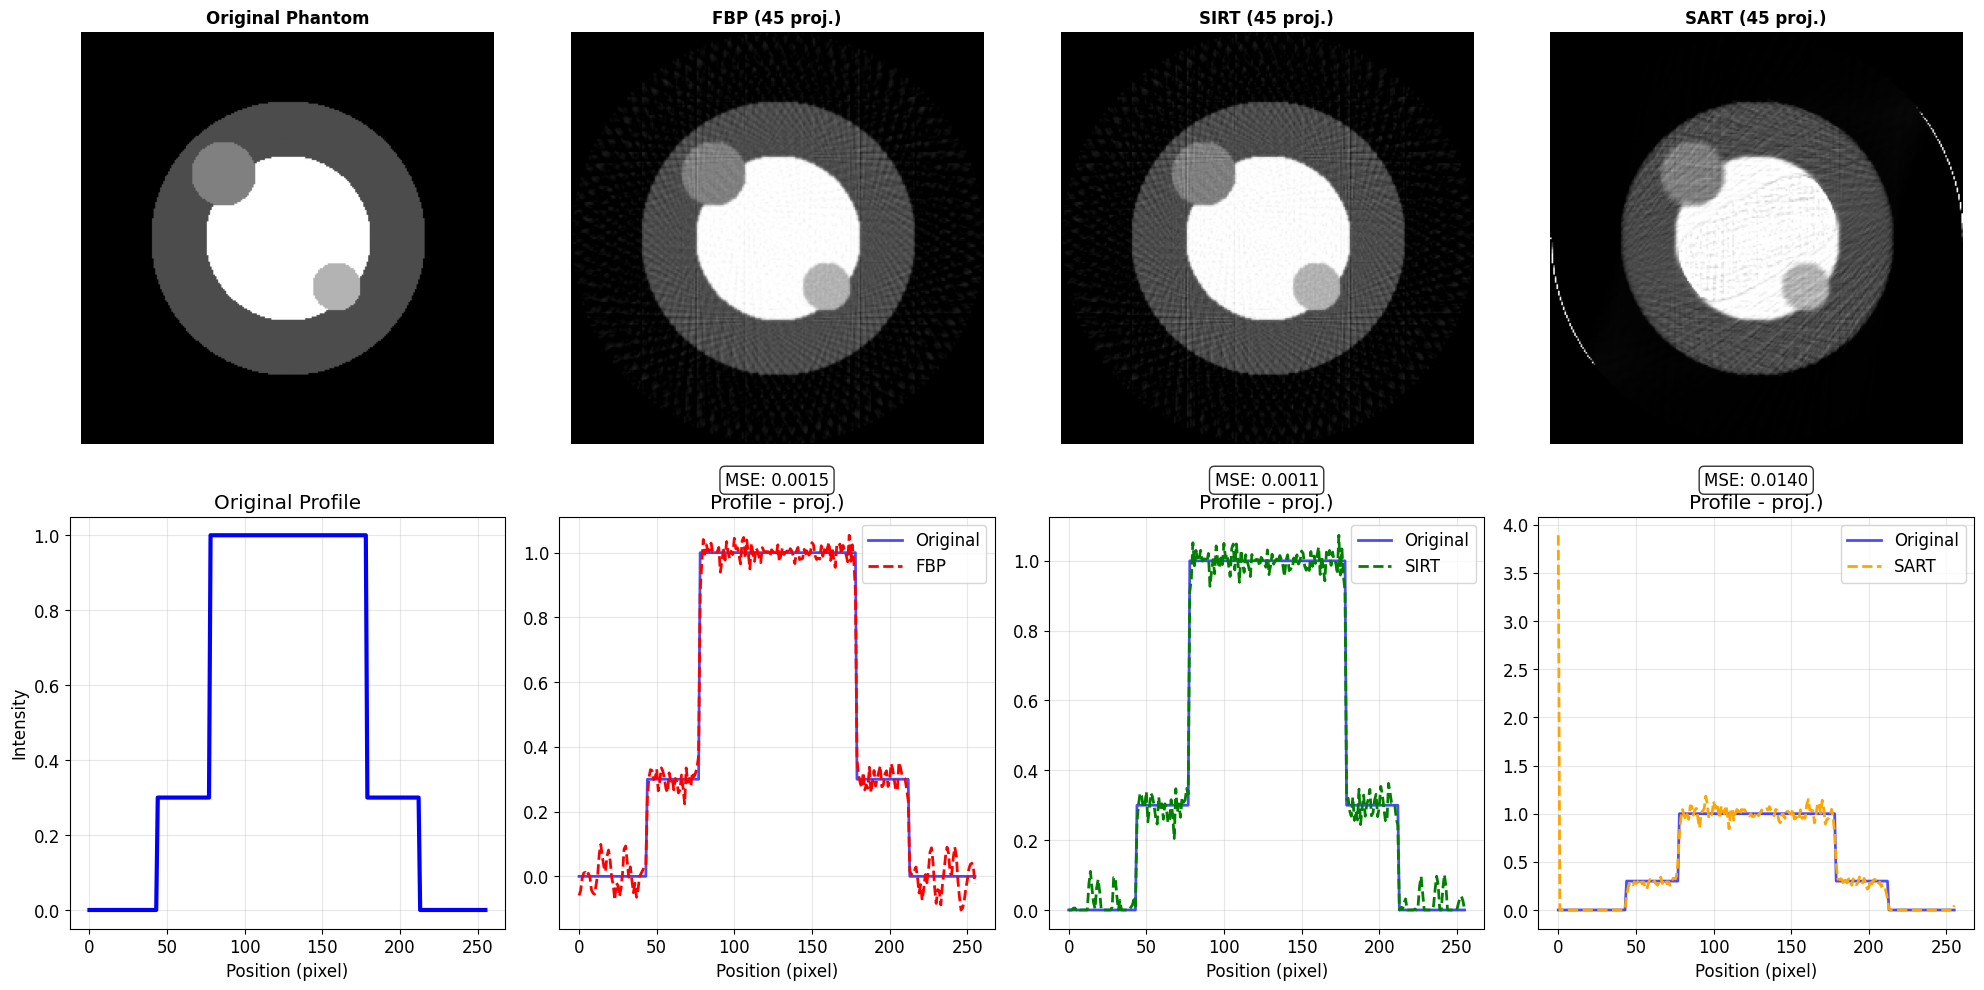


📊 QUALITY METRICS
Method               MSE          PSNR       SSIM      
------------------------------------------------------------
FBP (45 proj.)       0.001535     28.14      0.9935    
SIRT (45 proj.)      0.001141     29.43      0.9947    
SART (45 proj.)      0.014002     18.54      0.9428    


In [25]:
# Comparative visualization: FBP vs Iterative Methods
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

# First row: reconstructed images
images = [phantom_simple, recon_fbp_sparse, recon_sirt, recon_sart]
titles = ['Original Phantom', 'FBP (45 proj.)', 'SIRT (45 proj.)', 'SART (45 proj.)']

for i, (img, title) in enumerate(zip(images, titles)):
    axes[0, i].imshow(img, cmap='gray', vmin=0, vmax=1)
    axes[0, i].set_title(title, fontsize=12, fontweight='bold')
    axes[0, i].axis('off')

    # Calculate MSE for reconstructions
    if i > 0:
        mse = np.mean((phantom_simple - img)**2)
        axes[0, i].text(0.5, -0.1, f'MSE: {mse:.4f}',
                       transform=axes[0, i].transAxes, ha='center',
                       bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Second row: central profiles
center_row = phantom_simple.shape[0] // 2
original_profile = phantom_simple[center_row, :]

for i, (img, title) in enumerate(zip(images, titles)):
    if i == 0:
        axes[1, i].plot(original_profile, 'b-', linewidth=3, label='Original')
        axes[1, i].set_title('Original Profile')
        axes[1, i].set_ylabel('Intensity')
    else:
        profile = img[center_row, :]
        axes[1, i].plot(original_profile, 'b-', linewidth=2, alpha=0.7, label='Original')

        if i == 1:  # FBP
            axes[1, i].plot(profile, 'r--', linewidth=2, label='FBP')
        elif i == 2:  # SIRT
            axes[1, i].plot(profile, 'g--', linewidth=2, label='SIRT')
        else:  # SART
            axes[1, i].plot(profile, 'orange', linestyle='--', linewidth=2, label='SART')

        axes[1, i].set_title(f'Profile - {title.split()[-1]}')
        axes[1, i].legend()

    axes[1, i].grid(True, alpha=0.3)
    axes[1, i].set_xlabel('Position (pixel)')
    if i == 0:
        axes[1, i].set_ylabel('Intensity')

plt.tight_layout()
plt.show()

# Calculate and display metrics
methods = {
    'FBP (45 proj.)': recon_fbp_sparse,
    'SIRT (45 proj.)': recon_sirt,
    'SART (45 proj.)': recon_sart
}

print("\n📊 QUALITY METRICS")
print("=" * 60)
print(f"{'Method':<20} {'MSE':<12} {'PSNR':<10} {'SSIM':<10}")
print("-" * 60)

for method_name, reconstruction in methods.items():
    metrics = calculate_quality_metrics(phantom_simple, reconstruction)
    print(f"{method_name:<20} {metrics['MSE']:<12.6f} {metrics['PSNR']:<10.2f} {metrics['SSIM']:<10.4f}")


### 🎯 **Exercise 4**: Analysis of Iterative Parameter Effects

Let's study how iterative method parameters influence reconstruction:

1. **Number of iterations**: More iterations = better quality (up to convergence)
2. **Relaxation parameter**: Controls convergence speed


🔬 Test Effect of Number of Iterations

🧪 Test with 5 iterations...
🔄 Starting SIRT with 5 iterations...
✅ SIRT completed!
   ✅ Completed - MSE: 0.001174

🧪 Test with 15 iterations...
🔄 Starting SIRT with 15 iterations...
   Iteration 10/15: Sinogram Error = 219.342196, Image MSE = 0.001152
✅ SIRT completed!
   ✅ Completed - MSE: 0.001124

🧪 Test with 30 iterations...
🔄 Starting SIRT with 30 iterations...
   Iteration 10/30: Sinogram Error = 219.342196, Image MSE = 0.001152
   Iteration 20/30: Sinogram Error = 190.257589, Image MSE = 0.001108
   Iteration 30/30: Sinogram Error = 169.726117, Image MSE = 0.001073
✅ SIRT completed!
   ✅ Completed - MSE: 0.001070

🧪 Test with 50 iterations...
🔄 Starting SIRT with 50 iterations...
   Iteration 10/50: Sinogram Error = 219.342196, Image MSE = 0.001152
   Iteration 20/50: Sinogram Error = 190.257589, Image MSE = 0.001108
   Iteration 30/50: Sinogram Error = 169.726117, Image MSE = 0.001073
   Iteration 40/50: Sinogram Error = 154.923949, Image 

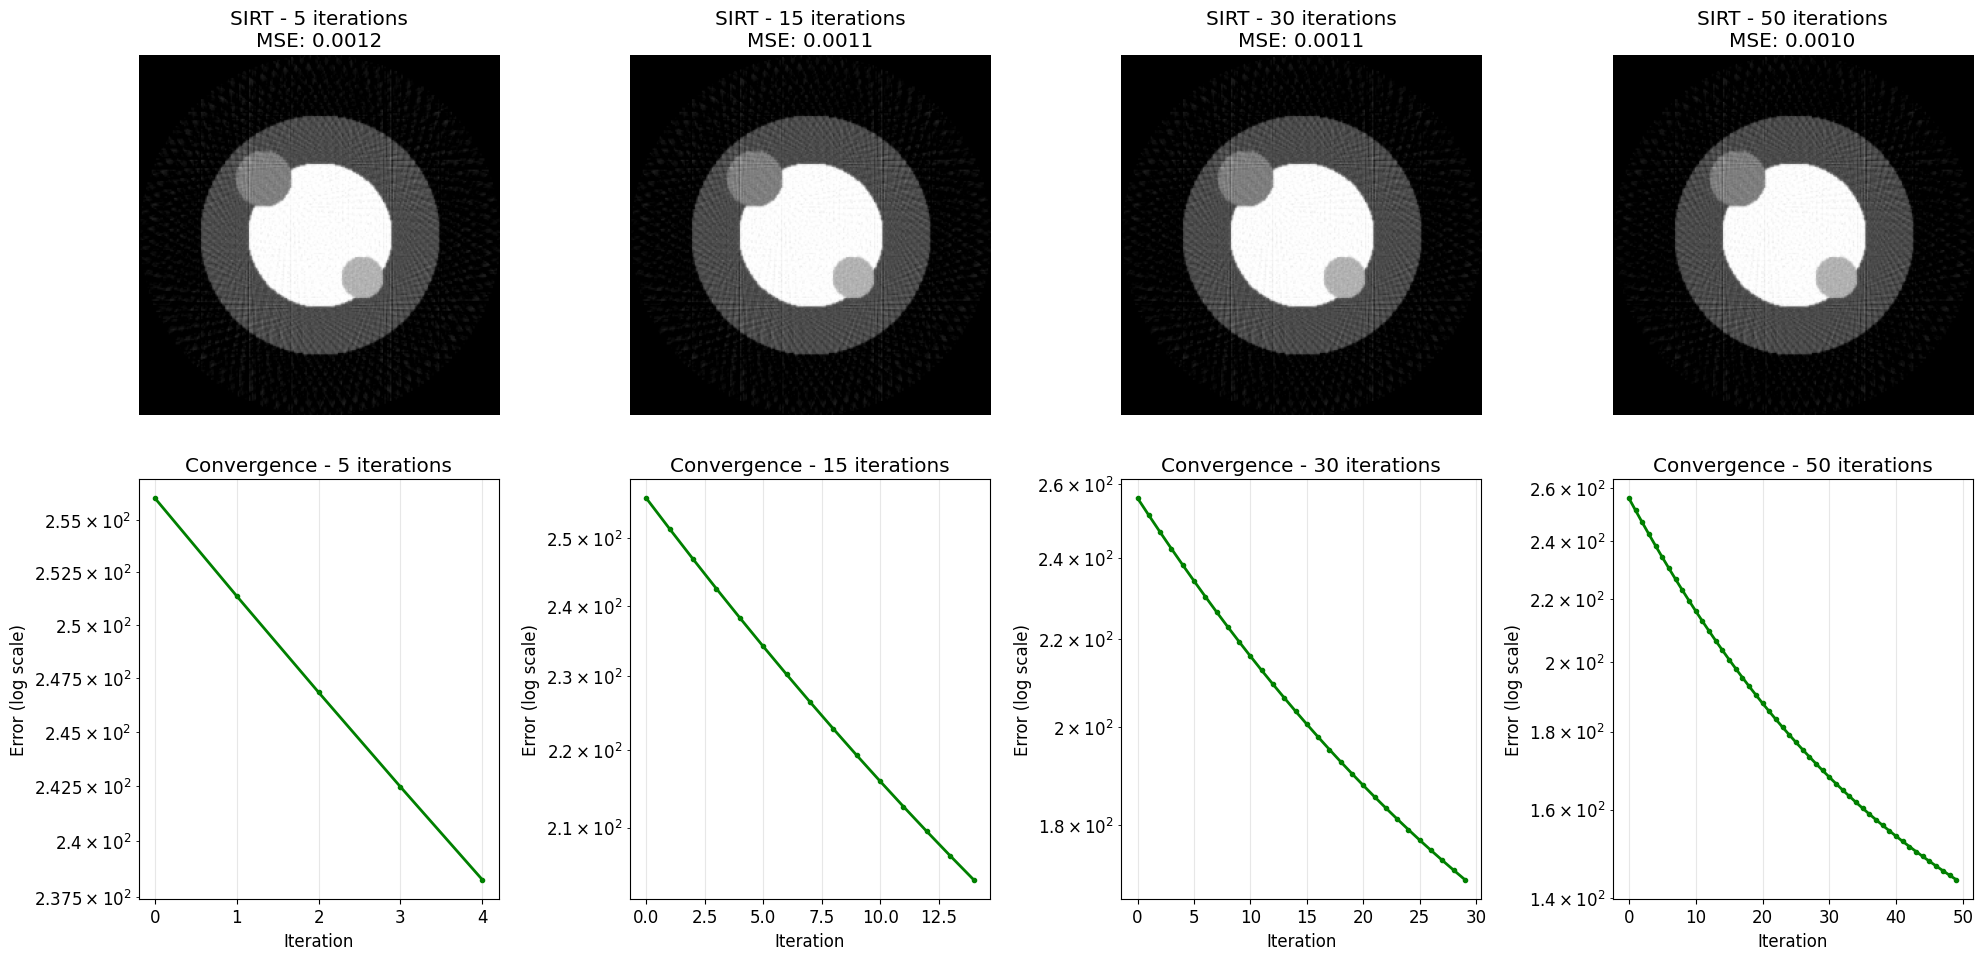


📊 NUMBER OF ITERATIONS ANALYSIS
Iterations   MSE          Final Error     Improvement    
--------------------------------------------------
5            0.001174     238.270403      0.0            %
15           0.001124     203.515307      4.3            %
30           0.001070     169.726117      8.8            %
50           0.001020     143.912872      13.1           %


In [31]:
# Test of the effect of number of iterations
print("🔬 Test Effect of Number of Iterations")
print("=" * 50)

iterations_to_test = [5, 15, 30, 50]
results_iterations = {}

for n_iter in iterations_to_test:
    print(f"\n🧪 Test with {n_iter} iterations...")

    # SIRT with different number of iterations
    recon, errors, image_errors = sirt_reconstruction(
        sinogram_sparse,
        angles_sparse,
        n_iterations=n_iter,
        relaxation=0.8,
        reference_image=phantom_simple
    )

    results_iterations[n_iter] = {
        'reconstruction': recon,
        'errors': errors,
        'final_error': errors[-1],
        'mse': np.mean((phantom_simple - recon)**2)
    }

    print(f"   ✅ Completed - MSE: {results_iterations[n_iter]['mse']:.6f}")

# Results visualization
fig, axes = plt.subplots(2, len(iterations_to_test), figsize=(20, 10))

for i, n_iter in enumerate(iterations_to_test):
    result = results_iterations[n_iter]

    # First row: reconstructed images
    axes[0, i].imshow(result['reconstruction'], cmap='gray', vmin=0, vmax=1)
    axes[0, i].set_title(f'SIRT - {n_iter} iterations\nMSE: {result["mse"]:.4f}')
    axes[0, i].axis('off')

    # Second row: convergence curves
    axes[1, i].semilogy(result['errors'], 'g-', linewidth=2, marker='o', markersize=3)
    axes[1, i].set_title(f'Convergence - {n_iter} iterations')
    axes[1, i].set_xlabel('Iteration')
    axes[1, i].set_ylabel('Error (log scale)')
    axes[1, i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Results analysis
print("\n📊 NUMBER OF ITERATIONS ANALYSIS")
print("=" * 50)
print(f"{'Iterations':<12} {'MSE':<12} {'Final Error':<15} {'Improvement':<15}")
print("-" * 50)

for n_iter in iterations_to_test:
    result = results_iterations[n_iter]
    improvement = ((results_iterations[iterations_to_test[0]]['mse'] - result['mse']) /
                   results_iterations[iterations_to_test[0]]['mse'] * 100)

    print(f"{n_iter:<12} {result['mse']:<12.6f} {result['final_error']:<15.6f} {improvement:<15.1f}%")



🔬 Test Effect of Relaxation Parameter

🧪 Test with relaxation = 0.2...
🔄 Starting SIRT with 30 iterations...
   Iteration 10/30: Sinogram Error = 245.833137, Image MSE = 0.001191
   Iteration 20/30: Sinogram Error = 235.390750, Image MSE = 0.001176
   Iteration 30/30: Sinogram Error = 225.833818, Image MSE = 0.001162
✅ SIRT completed!
   ✅ Completed - MSE: 0.001160

🧪 Test with relaxation = 0.5...
🔄 Starting SIRT with 30 iterations...
   Iteration 10/30: Sinogram Error = 231.846782, Image MSE = 0.001170
   Iteration 20/30: Sinogram Error = 210.066323, Image MSE = 0.001138
   Iteration 30/30: Sinogram Error = 192.609683, Image MSE = 0.001111
✅ SIRT completed!
   ✅ Completed - MSE: 0.001109

🧪 Test with relaxation = 0.8...
🔄 Starting SIRT with 30 iterations...
   Iteration 10/30: Sinogram Error = 219.342196, Image MSE = 0.001152
   Iteration 20/30: Sinogram Error = 190.257589, Image MSE = 0.001108
   Iteration 30/30: Sinogram Error = 169.726117, Image MSE = 0.001073
✅ SIRT completed!
  

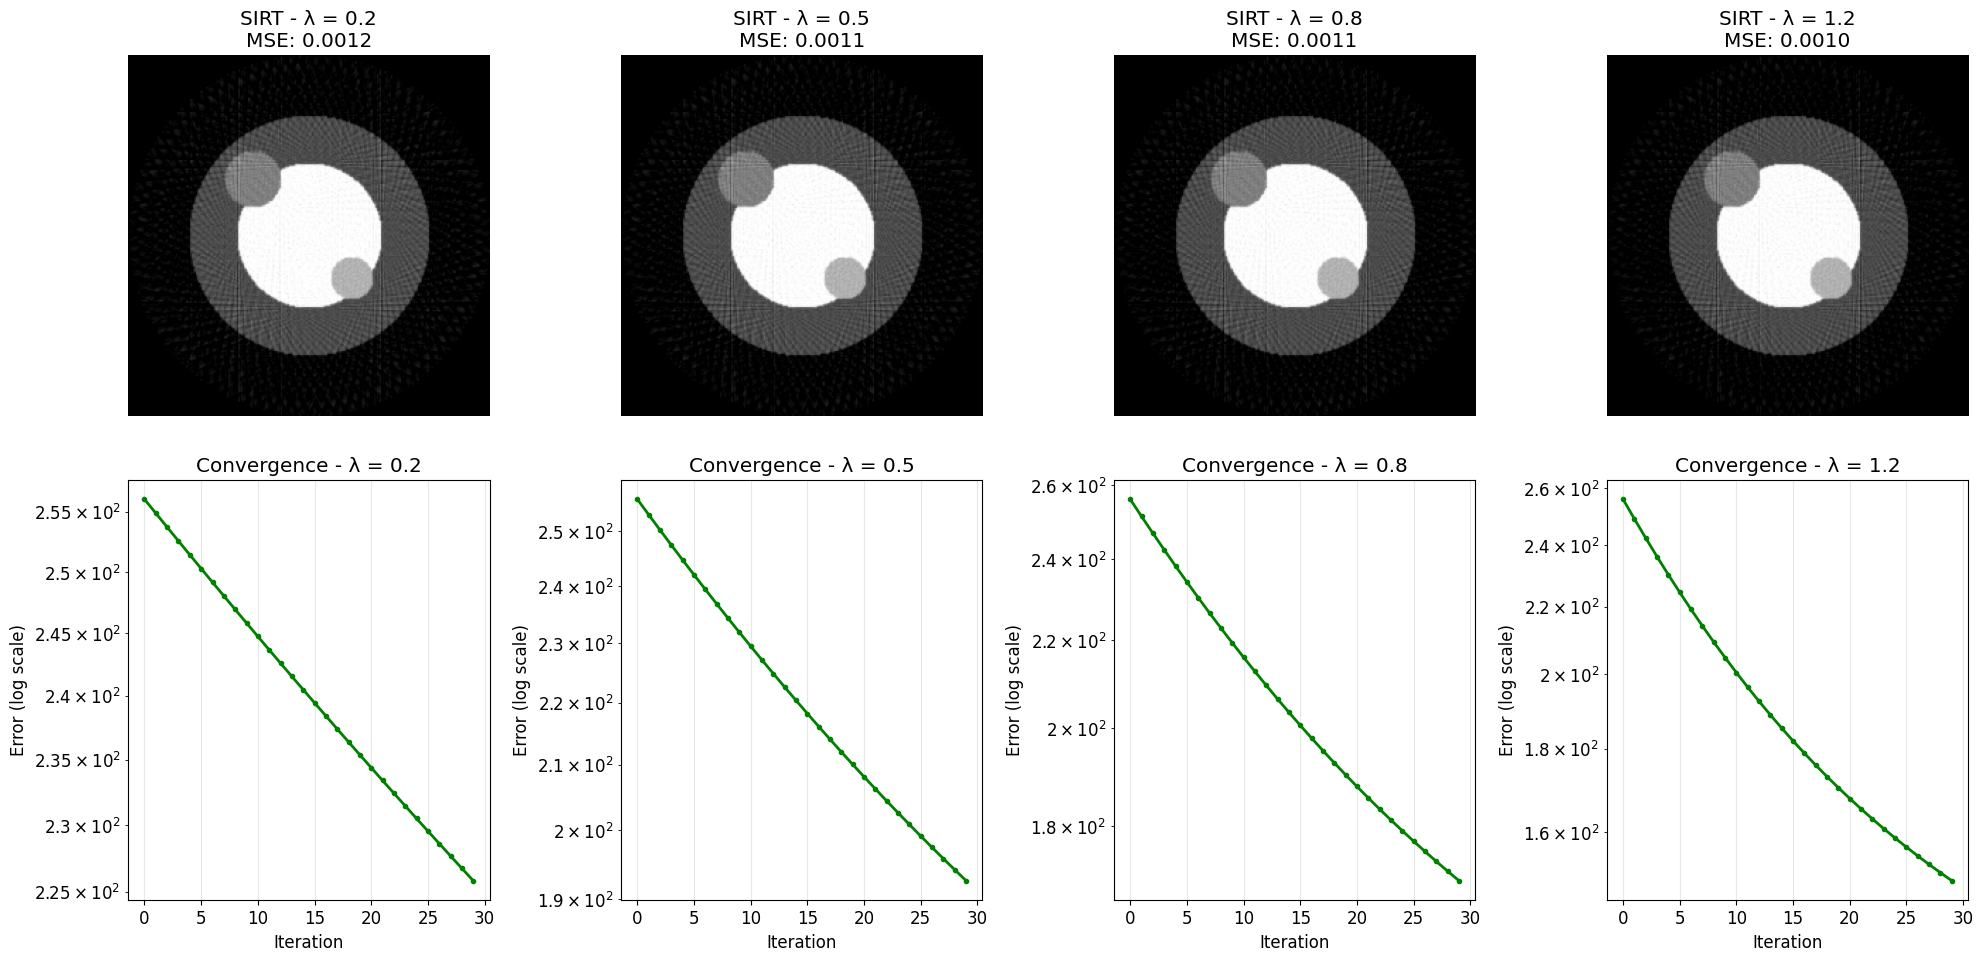


📊 RELAXATION PARAMETER ANALYSIS
Relaxation   MSE          Final Error     Conv. Speed    
------------------------------------------------------------
0.2          0.001160     225.833818      0.003934       
0.5          0.001109     192.609683      0.008259       
0.8          0.001070     169.726117      0.011238       
1.2          0.001031     149.381763      0.013887       

💡 OBSERVATIONS:
- λ too small (0.2): Slow convergence
- λ optimal (0.8): Balance between speed and stability
- λ too large (1.2): Possible instability or oscillations


In [32]:
# Test of relaxation parameter effect
print("\n🔬 Test Effect of Relaxation Parameter")
print("=" * 50)

relaxation_values = [0.2, 0.5, 0.8, 1.2]
results_relaxation = {}

for relax in relaxation_values:
    print(f"\n🧪 Test with relaxation = {relax}...")

    # SIRT with different relaxation parameter
    recon, errors, image_errors = sirt_reconstruction(
        sinogram_sparse,
        angles_sparse,
        n_iterations=30,  # Fixed number of iterations
        relaxation=relax,
        reference_image=phantom_simple
    )

    results_relaxation[relax] = {
        'reconstruction': recon,
        'errors': errors,
        'final_error': errors[-1],
        'mse': np.mean((phantom_simple - recon)**2),
        'convergence_rate': len(errors)  # Number of iterations for convergence
    }

    print(f"   ✅ Completed - MSE: {results_relaxation[relax]['mse']:.6f}")

# Results visualization
fig, axes = plt.subplots(2, len(relaxation_values), figsize=(20, 10))

for i, relax in enumerate(relaxation_values):
    result = results_relaxation[relax]

    # First row: reconstructed images
    axes[0, i].imshow(result['reconstruction'], cmap='gray', vmin=0, vmax=1)
    axes[0, i].set_title(f'SIRT - λ = {relax}\nMSE: {result["mse"]:.4f}')
    axes[0, i].axis('off')

    # Second row: convergence curves
    axes[1, i].semilogy(result['errors'], 'g-', linewidth=2, marker='o', markersize=3)
    axes[1, i].set_title(f'Convergence - λ = {relax}')
    axes[1, i].set_xlabel('Iteration')
    axes[1, i].set_ylabel('Error (log scale)')
    axes[1, i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Results analysis
print("\n📊 RELAXATION PARAMETER ANALYSIS")
print("=" * 60)
print(f"{'Relaxation':<12} {'MSE':<12} {'Final Error':<15} {'Conv. Speed':<15}")
print("-" * 60)

for relax in relaxation_values:
    result = results_relaxation[relax]
    # Convergence speed = how quickly error decreases
    if len(result['errors']) > 1:
        initial_error = result['errors'][0]
        final_error = result['errors'][-1]
        convergence_rate = (initial_error - final_error) / initial_error / len(result['errors'])
    else:
        convergence_rate = 0

    print(f"{relax:<12} {result['mse']:<12.6f} {result['final_error']:<15.6f} {convergence_rate:<15.6f}")

print("\n💡 OBSERVATIONS:")
print("- λ too small (0.2): Slow convergence")
print("- λ optimal (0.8): Balance between speed and stability")
print("- λ too large (1.2): Possible instability or oscillations")

## 🧠 BONUS: Deep Learning for CT Reconstruction

Deep learning is revolutionizing CT reconstruction! Let's see a simple example of how a neural network can improve reconstructions with few projections.


### Deep Learning Approaches in CT

1. **Post-processing**: Neural network improves FBP reconstruction
2. **End-to-end**: Neural network completely replaces FBP
3. **Learned Primal-Dual**: Combines iterative algorithms with DL
4. **Physics-informed**: Incorporates physical laws into the network

**Advantages:**
- Drastic noise reduction
- Reconstruction from few projections (sparse-view CT)
- Radiation dose reduction
- High computational speed

**Challenges:**
- Need for large training datasets
- Interpretability of results
- Generalization to new data types


In [33]:
pip install tensorflow

In [27]:
# Simple example: Neural Network for Post-Processing
# NOTE: This is a demonstrative example - complete training would require much more data
try:
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras import layers
    tensorflow_available = True
    print("✅ TensorFlow available!")
except ImportError:
    tensorflow_available = False
    print("⚠️  TensorFlow not installed. We only show the network architecture.")

def create_denoising_cnn():
    """
    Creates a simple CNN network for CT image denoising
    Architecture: Encoder-Decoder with skip connections (simplified U-Net)
    """
    if not tensorflow_available:
        print("Network architecture (conceptual):")
        print("Input (256x256x1) -> Conv2D(32) -> Conv2D(64) -> Conv2D(128)")
        print("-> Decoder: UpSampling + Conv2D(64) -> Conv2D(32) -> Conv2D(1)")
        print("-> Output (256x256x1)")
        return None

    inputs = keras.Input(shape=(256, 256, 1))

    # Encoder
    x1 = layers.Conv2D(32, 3, activation="relu", padding="same")(inputs)
    x1 = layers.Conv2D(32, 3, activation="relu", padding="same")(x1)
    p1 = layers.MaxPooling2D(2)(x1)

    x2 = layers.Conv2D(64, 3, activation="relu", padding="same")(p1)
    x2 = layers.Conv2D(64, 3, activation="relu", padding="same")(x2)
    p2 = layers.MaxPooling2D(2)(x2)

    # Bottleneck
    x3 = layers.Conv2D(128, 3, activation="relu", padding="same")(p2)
    x3 = layers.Conv2D(128, 3, activation="relu", padding="same")(x3)

    # Decoder
    u1 = layers.UpSampling2D(2)(x3)
    u1 = layers.concatenate([u1, x2])
    x4 = layers.Conv2D(64, 3, activation="relu", padding="same")(u1)
    x4 = layers.Conv2D(64, 3, activation="relu", padding="same")(x4)

    u2 = layers.UpSampling2D(2)(x4)
    u2 = layers.concatenate([u2, x1])
    x5 = layers.Conv2D(32, 3, activation="relu", padding="same")(u2)
    x5 = layers.Conv2D(32, 3, activation="relu", padding="same")(x5)

    # Output
    outputs = layers.Conv2D(1, 1, activation="linear", padding="same")(x5)

    model = keras.Model(inputs, outputs)
    return model

# Create the model
model = create_denoising_cnn()

if tensorflow_available:
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    print(f"✅ Model created with {model.count_params():,} parameters")

    # Show the architecture
    print("\n📋 NETWORK ARCHITECTURE:")
    model.summary()


✅ TensorFlow available!
✅ Model created with 470,977 parameters

📋 NETWORK ARCHITECTURE:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      9,248 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 128, 128,  │          0 │ conv2d_5[0][0]    │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128, 128,  │          0 │ up_sampling2d[0]… │
│ (Concatenate)       │ 192)              │            │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 128, 128,  │    110,656 │ concatenate[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d_6[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 256, 256,  │          0 │ conv2d_7[0][0]    │
│ (UpSampling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 256, 256,  │          0 │ up_sampling2d_1[… │
│ (Concatenate)       │ 96)               │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 256, 256,  │     27,680 │ concatenate_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 256, 256,  │      9,248 │ conv2d_8[0][0]  

 Total params: 470,977 (1.80 MB)

 Trainable params: 470,977 (1.80 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
# Simulate Deep Learning effect
# Create synthetic training data to demonstrate the concept

def create_training_data(n_samples=50):
    """
    Create synthetic dataset for training:
    - Input: FBP reconstructions with few projections (noisy)
    - Target: FBP reconstructions with many projections (clean)
    """
    X_train = []  # Noisy inputs
    y_train = []  # Clean targets

    print("🔧 Generating training dataset...")

    for i in range(n_samples):
        # Create random phantom
        phantom = create_simple_phantom(256)
        # Add random variations
        noise = np.random.normal(0, 0.1, phantom.shape)
        phantom_variant = np.clip(phantom + noise, 0, 1)

        # "Clean" reconstruction (many projections)
        sino_clean, angles_clean = simulate_ct_acquisition(phantom_variant, n_angles=180, noise_level=0.01)
        recon_clean = fbp_reconstruction(sino_clean, angles_clean, 'shepp-logan')

        # "Noisy" reconstruction (few projections + noise)
        sino_noisy, angles_noisy = simulate_ct_acquisition(phantom_variant, n_angles=45, noise_level=0.1)
        recon_noisy = fbp_reconstruction(sino_noisy, angles_noisy, 'shepp-logan')

        X_train.append(recon_noisy[..., np.newaxis])  # Add channel dimension 1: grayscale -> CNN request
        y_train.append(recon_clean[..., np.newaxis])

        if (i + 1) % 10 == 0:
            print(f"  Generated {i + 1}/{n_samples} samples")

    return np.array(X_train), np.array(y_train)

# Create reduced dataset for demonstration
if tensorflow_available:
    X_train, y_train = create_training_data(20)  # Very small dataset for demo
    print(f"✅ Dataset created: X_train {X_train.shape}, y_train {y_train.shape}")
else:
    print("📊 Conceptual dataset:")
    print("X_train: (20, 256, 256, 1) - Reconstructions with 45 projections + noise")
    print("y_train: (20, 256, 256, 1) - Reconstructions with 180 clean projections")

🔧 Generating training dataset...
  Generated 10/20 samples
  Generated 20/20 samples
✅ Dataset created: X_train (20, 256, 256, 1), y_train (20, 256, 256, 1)


🚀 Model training (accelerated version for demo)...
Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 21s 961ms/step - loss: 0.0983 - mae: 0.1805 - val_loss: 0.0044 - val_mae: 0.0552
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.0203 - mae: 0.0823 - val_loss: 0.0462 - val_mae: 0.1226
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.0420 - mae: 0.1171 - val_loss: 0.0197 - val_mae: 0.0851
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0133 - mae: 0.0723 - val_loss: 0.0081 - val_mae: 0.0781
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.0092 - mae: 0.0802 - val_loss: 0.0027 - val_mae: 0.0418
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.0024 - mae: 0.0377 - val_loss: 0.0033 - val_mae: 0.0403
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.0028 - mae: 0.0370 - val_loss: 0.0014 - val_mae: 0.0278
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.0016 - mae: 0.0298 - val_loss: 0.0019 - val_mae: 0.0324
Epoch 9/10
4/4 ━━━━━━━━━━━━

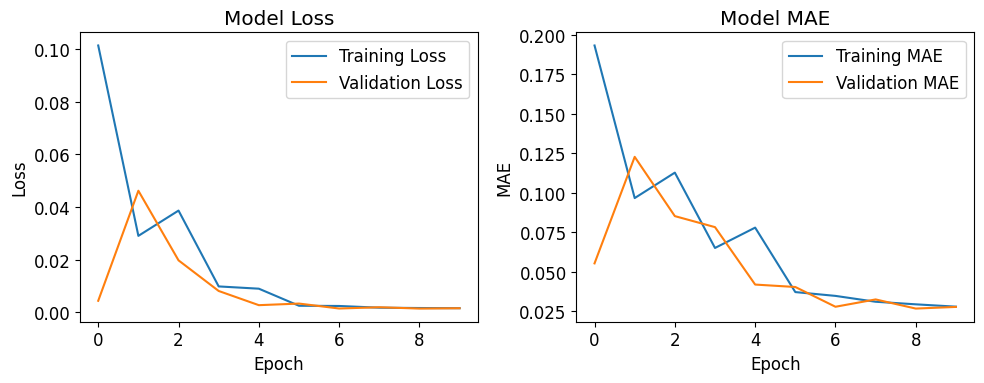

In [36]:
# Quick model training (for demonstration only)
if tensorflow_available and 'X_train' in locals():
    print("🚀 Model training (accelerated version for demo)...")

    # Very brief training - in reality many more epochs and data would be needed
    history = model.fit(
        X_train, y_train,
        epochs=10,  # In reality 100+ epochs would be needed
        batch_size=4,
        validation_split=0.2,
        verbose=1
    )

    print("✅ Training completed!")

    # Show the loss
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title('Model MAE')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend()

    plt.tight_layout()
    plt.show()

else:
    print("📈 Training process (conceptual):")
    print("1. Define loss function (MSE or MAE)")
    print("2. Optimizer (Adam)")
    print("3. Training for 100+ epochs")
    print("4. Monitoring validation loss")
    print("5. Early stopping to avoid overfitting")

### 🔍 **Explanation of the Test Section**

**What we are about to do:**

1. **Create a new phantom** (different from those used for training)
2. **Simulate a real scenario**: Few projections (45 instead of 180) + noise
3. **Compare 3 methods**:
   - 🔴 **FBP with few projections** (traditional method, low quality)
   - 🔴 **SIRT with few projections**
   - 🔴 **SART with few projections**
   - 🟢 **Deep Learning** (our trained model)
   - 🔵 **Reference FBP** (many projections, high quality but high dose)

**Goal:** See if Deep Learning can achieve quality similar to the reference using only 45 projections (instead of 180)

In [37]:
print("🧪 START OF DEEP LEARNING TEST")
print("=" * 50)

# STEP 1: Create a new phantom for testing
print("1️⃣ Creating test phantom...")
phantom_test_dl = create_simple_phantom(256)
print(f"   ✅ Phantom created: {phantom_test_dl.shape}")

# STEP 2: Simulate acquisition with FEW projections (realistic scenario)
print("\n2️⃣ Acquisition with few projections (sparse-view CT)...")
sino_sparse, angles_sparse = simulate_ct_acquisition(
    phantom_test_dl,
    n_angles=45,      # Only 45 projections instead of 180!
    noise_level=0.1   # With realistic noise
)
print(f"   ✅ Sinogram: {sino_sparse.shape} with {len(angles_sparse)} projections")

# STEP 3: Traditional FBP reconstruction (baseline method)
print("\n3️⃣ Traditional FBP reconstruction...")
recon_fbp_sparse = fbp_reconstruction(sino_sparse, angles_sparse, 'shepp-logan')
print(f"   ✅ FBP completed: {recon_fbp_sparse.shape}")

# STEP 4: SIRT reconstruction
print("\n4️⃣ SIRT reconstruction...")
recon_sirt_sparse, errors_sirt_sparse, image_errors_sirt_sparse = sirt_reconstruction(
        sino_sparse,
        angles_sparse,
        n_iterations=30,  # Fixed number of iterations
        relaxation=0.8,
        reference_image=phantom_test_dl
    )
print(f"   ✅ SIRT completed: {recon_sirt_sparse.shape}")

# STEP 5: SART reconstruction
print("\n5️⃣ SART reconstruction...")
recon_sart_sparse, errors_sart_sparse = sart_reconstruction(
    sino_sparse,
    angles_sparse,
    n_iterations=30,
    relaxation=0.8
)
print(f"   ✅ SART completed: {recon_sart_sparse.shape}")

# STEP 6: REFERENCE reconstruction (ideal quality)
print("\n6️⃣ Reference reconstruction (many projections)...")
sino_reference, angles_reference = simulate_ct_acquisition(
    phantom_test_dl,
    n_angles=180,     # Many projections
    noise_level=0.01  # Low noise
)
recon_reference = fbp_reconstruction(sino_reference, angles_reference, 'shepp-logan')
print(f"   ✅ Reference completed: {recon_reference.shape}")

print("\n🎯 PREPARATION COMPLETED! Now let's test Deep Learning...")

🧪 START OF DEEP LEARNING TEST
1️⃣ Creating test phantom...
   ✅ Phantom created: (256, 256)

2️⃣ Acquisition with few projections (sparse-view CT)...
   ✅ Sinogram: (256, 45) with 45 projections

3️⃣ Traditional FBP reconstruction...
   ✅ FBP completed: (256, 256)

4️⃣ SIRT reconstruction...
🔄 Starting SIRT with 30 iterations...
   Iteration 10/30: Sinogram Error = 222.208436, Image MSE = 0.001186
   Iteration 20/30: Sinogram Error = 192.769293, Image MSE = 0.001140
   Iteration 30/30: Sinogram Error = 171.963411, Image MSE = 0.001105
✅ SIRT completed!
   ✅ SIRT completed: (256, 256)

5️⃣ SART reconstruction...
🔄 Starting SART with 30 iterations...
   Iteration 10/30: Error = 2.845521
   Iteration 20/30: Error = 0.970739
   Iteration 30/30: Error = 0.533456
✅ SART completed!
   ✅ SART completed: (256, 256)

6️⃣ Reference reconstruction (many projections)...
   ✅ Reference completed: (256, 256)

🎯 PREPARATION COMPLETED! Now let's test Deep Learning...


In [38]:
# STEP 5: DEEP LEARNING APPLICATION

if tensorflow_available and 'model' in locals():
    print("5️⃣ Applying Deep Learning...")

    # Prepare input for neural network
    print("   🔧 Preparing input...")
    input_dl = recon_fbp_sparse[np.newaxis, ..., np.newaxis]
    print(f"   📐 Input shape: {input_dl.shape} (batch_size, height, width, channels)")

    # Apply neural network
    print("   🧠 Neural network prediction...")
    recon_dl = model.predict(input_dl, verbose=0)[0, ..., 0]
    print(f"   ✅ Prediction completed: {recon_dl.shape}")

    # Calculate quality metrics
    print("\n📊 CALCULATING METRICS:")
    mse_fbp = np.mean((phantom_test_dl - recon_fbp_sparse)**2)
    mse_sirt = np.mean((phantom_test_dl - recon_sirt_sparse)**2)
    mse_sart = np.mean((phantom_test_dl - recon_sart_sparse)**2)
    mse_dl = np.mean((phantom_test_dl - recon_dl)**2)
    mse_ref = np.mean((phantom_test_dl - recon_reference)**2)

    improvement = ((mse_fbp - mse_dl) / mse_fbp * 100)

    print(f"   🔴 MSE FBP (45 proj.):     {mse_fbp:.6f}")
    print(f"   🔴 MSE SIRT (45 proj.):    {mse_sirt:.6f}")
    print(f"   🔴 MSE SART (45 proj.):    {mse_sart:.6f}")
    print(f"   🟢 MSE Deep Learning:      {mse_dl:.6f}")
    print(f"   🔵 MSE Reference:          {mse_ref:.6f}")
    print(f"   📈 DL Improvement:         {improvement:.1f}%")

    # Flag to indicate we have DL results
    dl_results_available = True

else:
    print("5️⃣ TensorFlow not available - Simulating results...")
    print("   🎯 Typical Deep Learning results:")
    print("   - MSE reduction: 40-60% compared to sparse FBP")
    print("   - Removal of streak artifacts")
    print("   - Preservation of fine details")

    dl_results_available = False

print("\n🎨 Preparing visualization...")

5️⃣ Applying Deep Learning...
   🔧 Preparing input...
   📐 Input shape: (1, 256, 256, 1) (batch_size, height, width, channels)
   🧠 Neural network prediction...
   ✅ Prediction completed: (256, 256)

📊 CALCULATING METRICS:
   🔴 MSE FBP (45 proj.):     0.001567
   🔴 MSE SIRT (45 proj.):    0.001102
   🔴 MSE SART (45 proj.):    0.002305
   🟢 MSE Deep Learning:      0.001390
   🔵 MSE Reference:          0.000324
   📈 DL Improvement:         11.3%

🎨 Preparing visualization...


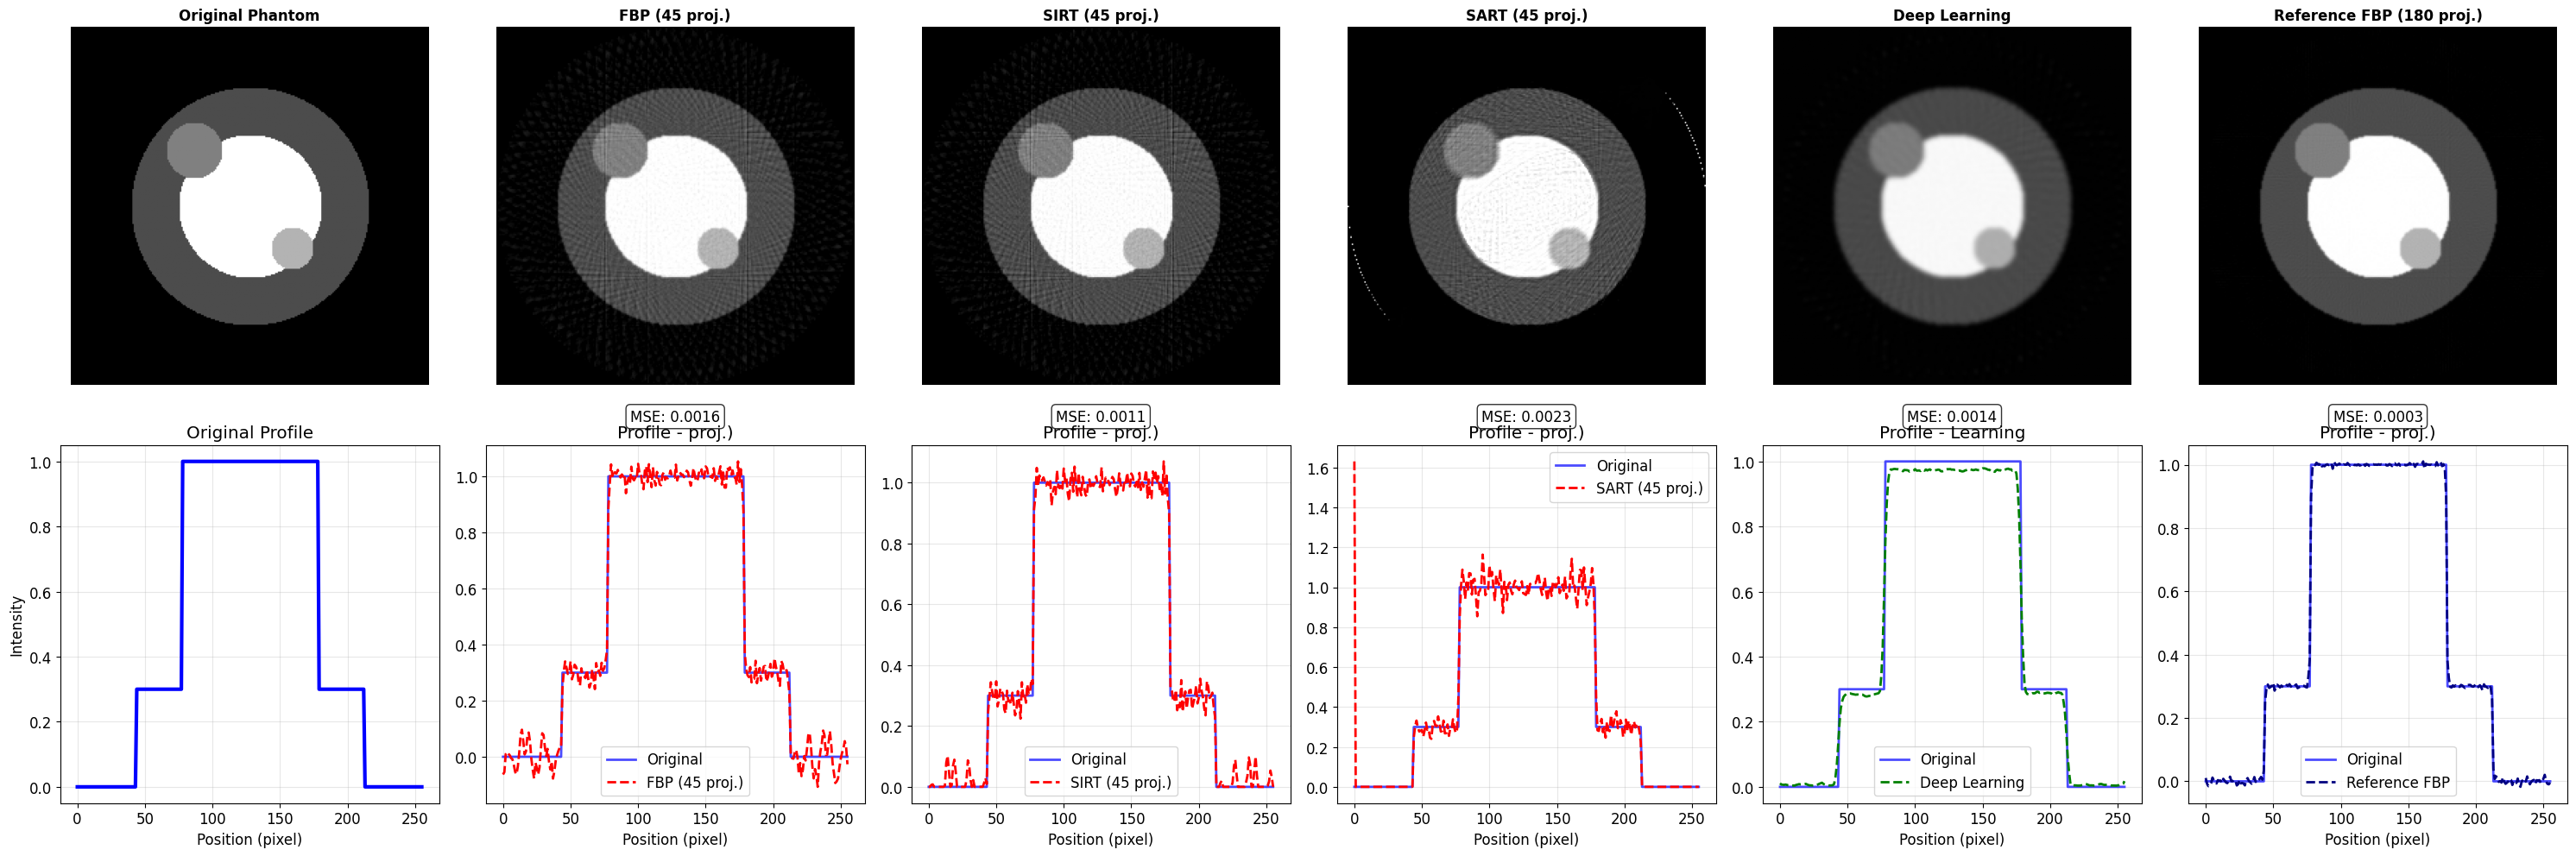


🏆 FINAL TEST RESULTS
FBP (45 projections):      MSE = 0.001567
SIRT (45 projections):     MSE = 0.001102
SART (45 projections):     MSE = 0.002305
Deep Learning:             MSE = 0.001390
Reference FBP:             MSE = 0.000324
DL Improvement:            11.3%
Dose efficiency:           75% projection reduction


In [39]:
# STEP 6: RESULTS VISUALIZATION

if dl_results_available:
    # Complete visualization with Deep Learning
    fig, axes = plt.subplots(2, 6, figsize=(30, 10))

    # First row: images
    images = [phantom_test_dl, recon_fbp_sparse, recon_sirt_sparse, recon_sart_sparse, recon_dl, recon_reference]
    titles = ['Original Phantom', 'FBP (45 proj.)', 'SIRT (45 proj.)', 'SART (45 proj.)', 'Deep Learning', 'Reference FBP (180 proj.)']

    for i, (img, title) in enumerate(zip(images, titles)):
        axes[0, i].imshow(img, cmap='gray', vmin=0, vmax=1)
        axes[0, i].set_title(title, fontsize=12, fontweight='bold')
        axes[0, i].axis('off')

        # Add MSE below each image (except original)
        if i > 0:
            if i == 1:  # FBP sparse
                mse_val = mse_fbp
            elif i == 2:  # SIRT
                mse_val = mse_sirt
            elif i == 3:  # SART
                mse_val = mse_sart
            elif i == 4:  # Deep Learning
                mse_val = mse_dl
            else:  # Reference
                mse_val = mse_ref

            axes[0, i].text(0.5, -0.1, f'MSE: {mse_val:.4f}',
                           transform=axes[0, i].transAxes, ha='center',
                           bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    # Second row: central profiles
    center_row = phantom_test_dl.shape[0] // 2
    original_profile = phantom_test_dl[center_row, :]

    for i, (img, title) in enumerate(zip(images, titles)):
        if i == 0:
            axes[1, i].plot(original_profile, 'b-', linewidth=3, label='Original')
            axes[1, i].set_title('Original Profile')
            axes[1, i].set_ylabel('Intensity')
        else:
            profile = img[center_row, :]
            axes[1, i].plot(original_profile, 'b-', linewidth=2, alpha=0.7, label='Original')

            if i == 1:  # FBP sparse
                axes[1, i].plot(profile, 'r--', linewidth=2, label='FBP (45 proj.)')
                color = 'red'
            elif i == 2:  # SIRT sparse
                axes[1, i].plot(profile, 'r--', linewidth=2, label='SIRT (45 proj.)')
                color = 'red'
            elif i == 3:  # SART sparse
                axes[1, i].plot(profile, 'r--', linewidth=2, label='SART (45 proj.)')
                color = 'red'
            elif i == 4:  # Deep Learning
                axes[1, i].plot(profile, 'g--', linewidth=2, label='Deep Learning')
                color = 'green'
            else:  # Reference
                axes[1, i].plot(profile, 'navy', linestyle='--', linewidth=2, label='Reference FBP')
                color = 'navy'

            axes[1, i].set_title(f'Profile - {title.split()[-1]}')
            axes[1, i].legend()

        axes[1, i].grid(True, alpha=0.3)
        axes[1, i].set_xlabel('Position (pixel)')
        if i == 0:
            axes[1, i].set_ylabel('Intensity')

    plt.tight_layout()
    plt.show()

    # Final summary
    print("\n" + "="*60)
    print("🏆 FINAL TEST RESULTS")
    print("="*60)
    print(f"FBP (45 projections):      MSE = {mse_fbp:.6f}")
    print(f"SIRT (45 projections):     MSE = {mse_sirt:.6f}")
    print(f"SART (45 projections):     MSE = {mse_sart:.6f}")
    print(f"Deep Learning:             MSE = {mse_dl:.6f}")
    print(f"Reference FBP:             MSE = {mse_ref:.6f}")
    print(f"DL Improvement:            {improvement:.1f}%")
    print(f"Dose efficiency:           {((180-45)/180*100):.0f}% projection reduction")

else:
    # Visualization without Deep Learning
    fig, axes = plt.subplots(1, 5, figsize=(25, 5))

    images = [phantom_test_dl, recon_fbp_sparse, recon_sirt_sparse, recon_sart_sparse, recon_reference]
    titles = ['Original Phantom', 'FBP (45 proj.)', 'SIRT (45 proj.)', 'SART (45 proj.)', 'Reference FBP (180 proj.)']

    for i, (img, title) in enumerate(zip(images, titles)):
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(title)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

    print("📊 Deep Learning would significantly improve quality!")

### 🔬 Deep Learning in CT: State of the Art

#### **Main Methods:**

1. **FBPConvNet** (2017): Post-processing of FBP reconstructions
2. **LEARN** (2018): End-to-end learning from sinogram
3. **U-Net for CT** (2018): Encoder-decoder architecture
4. **Learned Primal-Dual** (2018): Combines iterations and neural networks
5. **Deep Image Prior** (2019): Without training dataset
6. **Score-Based Models** (2021): Advanced generative approaches

#### **Real Applications:**

- **GE Healthcare**: TrueFidelity™ (FDA approved)
- **Siemens**: Advanced Modeled Iterative Reconstruction (ADMIRE)
- **Philips**: Iterative Model Reconstruction (IMR)
- **Canon**: Advanced intelligent Clear-IQ Engine (AiCE)

#### **Future Challenges:**

- **Robustness**: Generalization to different scanners
- **Interpretability**: Explaining network decisions
- **Regulation**: FDA/CE approval for clinical use
- **Ethics**: Bias in training data


### 📚 Resources for Further Study

**Books:**
- Kak & Slaney: "Principles of Computerized Tomographic Imaging"
- Herman: "Fundamentals of Computerized Tomography"

**Deep Learning for CT:**
- [FBPConvNet Paper](https://arxiv.org/abs/1611.03679)
- [Learned Primal-Dual](https://arxiv.org/abs/1707.06474)
- [Deep Learning CT Reconstruction Survey](https://arxiv.org/abs/1906.06972)

**Code and Tutorials:**
- [Scikit-Image Radon Transform](https://scikit-image.org/docs/stable/auto_examples/transform/plot_radon_transform.html)
- [ASTRA Toolbox](https://www.astra-toolbox.com/) (advanced CT algorithms)
- [TomoPy](https://tomopy.readthedocs.io/) (synchrotron tomography)
- [ODL Library](https://odlgroup.github.io/odl/) (Deep Learning + tomography)
